In [1]:
# Origem dos dados:
# https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [2]:
!pip install --quiet py7zr
!pip install --quiet optuna
!pip install --quiet pyspark
!pip install --quiet mlflow
!pip install --quiet fbprophet
!git clone https://github.com/vss-2/IF697-Projeto-Data-Science

     |████████████████████████████████| 71kB 3.5MB/s 
     |████████████████████████████████| 13.7MB 312kB/s 
     |████████████████████████████████| 266kB 4.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 163kB 26.1MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 112kB 31.6MB/s 
     |████████████████████████████████| 133kB 27.8MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 204.2MB 60kB/s 
     |████████████████████████████████| 204kB 44.0MB/s 
     |████████████████████████████████| 13.9MB 349kB/s 
     |████████████████████████████████| 1.1MB 47.5MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 163kB 4

In [3]:
# Usado para fazer map-reduce no calculo das medias de temperaturas nas decadas
# Para substituir os for's por map's e reduce's
import pyspark
from pyspark import SparkContext
sc = SparkContext("local", "first app")

In [4]:
# Dado que o Github suporta apenas arquivos de 25MB
# tive que zipar, e ainda assim, particionar o arquivo para mantê-lo lá.
import py7zr

arquivos = ['/content/IF697-Projeto-Data-Science/datasets/GlobalLandTemperaturesByCity.csv.7z.001', '/content/IF697-Projeto-Data-Science/datasets/GlobalLandTemperaturesByCity.csv.7z.002']
with open('GlobalLandTemperaturesByCity.csv.7z', 'ab') as output:
  for arq in arquivos:
    with open(arq, 'rb') as parte2:
      output.write(parte2.read())

zipado = py7zr.SevenZipFile('/content/GlobalLandTemperaturesByCity.csv.7z')
zipado.extractall(path='/content/IF697-Projeto-Data-Science/datasets/')
zipado.close()

zipado = py7zr.SevenZipFile('/content/IF697-Projeto-Data-Science/datasets/GlobalLandTemperaturesByState.7z')
zipado.extractall(path='/content/IF697-Projeto-Data-Science/datasets/')
zipado.close()

## Introdução aos dados

*   Date: Contém datas no formato (AAAA-MM-DD). O início é no ano de 1750, para temperatura média da superfície da Terra e 1850, para temperatura máxima e mínima da superfície da Terra e oceanos.  

**Observação: Para todos os dados colunares abaixo há uma coluna adjacente que indica o intervalo de confiança de 95% ao redor da média.**

*    LandAverageTemperature
*    LandMaxTemperature
*    LandMinTemperature
*    LandAndOceanAverageTemperature

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)


df_cidade  = pd.read_csv('/content/IF697-Projeto-Data-Science/datasets/GlobalLandTemperaturesByCity.csv')
df_pais    = pd.read_csv('/content/IF697-Projeto-Data-Science/datasets/GlobalLandTemperaturesByCountry.csv')
df_mcidade = pd.read_csv('/content/IF697-Projeto-Data-Science/datasets/GlobalLandTemperaturesByMajorCity.csv')
df_estado  = pd.read_csv('/content/IF697-Projeto-Data-Science/datasets/GlobalLandTemperaturesByState.csv')
df_global  = pd.read_csv('/content/IF697-Projeto-Data-Science/datasets/GlobalTemperatures.csv')

dados_globais = df_pais
df_pais = pd.DataFrame(data = df_pais)

df_pais['AverageTemperature'] = df_pais['AverageTemperature'].astype('float')
df_pais['AverageTemperatureUncertainty'] = df_pais['AverageTemperatureUncertainty'].astype('float')
df_pais['Country'] = df_pais['Country'].astype('category')

df_cidade['AverageTemperature'] = df_cidade['AverageTemperature'].astype('float')
df_cidade['AverageTemperatureUncertainty'] = df_cidade['AverageTemperatureUncertainty'].astype('float')
df_cidade['Country'] = df_cidade['Country'].astype('category')
df_cidade['City'] = df_cidade['City'].astype('category')

# Datas estão no formato String, AAAA-MM-DD, converto para colunas independentes
# coloquei as colunas em português para ficar distinto dos dados originais, uso isso em groupbys
df_pais['Ano'] = df_pais['dt'].apply(lambda x: int(x[:4])).astype('int')
df_pais['Mes'] = df_pais['dt'].apply(lambda x: int(x[5:7])).astype('int')
df_pais['Dia'] = df_pais['dt'].apply(lambda x: int(x[-2:])).astype('int')

df_estado['State'] = df_estado['State'].astype('category')
df_estado['Country'] = df_estado['Country'].astype('category')

# Para uso em séries temporais:
df_pais['dt'] = pd.to_datetime(df_pais['dt'], format='%Y-%m-%d').astype('datetime64')
df_cidade['dt'] = pd.to_datetime(df_pais['dt'], format='%Y-%m-%d').astype('datetime64')
df_estado['dt'] = pd.to_datetime(df_estado['dt'], format='%Y-%m-%d').astype('datetime64')
df_global['dt'] = pd.to_datetime(df_global['dt'], format='%Y-%m-%d').astype('datetime64')

df_pais.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
Country                                category
Ano                                       int64
Mes                                       int64
Dia                                       int64
dtype: object

In [6]:
mapa1_temp_med = pd.DataFrame(df_pais.groupby('Country')['AverageTemperature'].mean())
mapa1_temp_med = mapa1_temp_med.reset_index()

# Por algum problema de caractere o país "Åland" está em último,
# colocamos ele na posição correta que deveria ser a 0.

mapa1_temp_med = mapa1_temp_med[len(mapa1_temp_med)-1:len(mapa1_temp_med)+1].append(mapa1_temp_med)
mapa1_temp_med = mapa1_temp_med[:-1]
mapa1_temp_med.reset_index(drop=False,inplace=True)
mapa1_temp_med.drop(labels='index', axis=1, inplace=True)
mapa1_temp_med

,Country,AverageTemperature
0,Åland,5.291383
1,Afghanistan,14.045007
2,Africa,24.074203
3,Albania,12.610646
4,Algeria,22.985112
...,...,...
238,Virgin Islands,26.336523
239,Western Sahara,22.319818
240,Yemen,26.253597
241,Zambia,21.282956


### Limpeza de dados
Verificamos que todos os registros de temperatura da Antarctica são do tipo "Not a Number" NaN, temos que removê-lo deste dataframe para plottar o mapa.

In [7]:
print(df_pais[df_pais['Country'] == 'Antarctica']['AverageTemperature'].isnull().sum() == \
len(df_pais[df_pais['Country'] == 'Antarctica']['AverageTemperature']))

mapa1_temp_med = mapa1_temp_med[mapa1_temp_med['Country'] != 'Antarctica']

True


In [8]:
import plotly.graph_objects as go
# Documentação: https://plotly.com/python/choropleth-maps/

mapa_df = pd.DataFrame(data={'Pais': mapa1_temp_med['Country'].unique(), 'Temperatura Media': mapa1_temp_med['AverageTemperature']})

figChoro = go.Figure(data = go.Choropleth(
                locations = mapa_df['Pais'],
                z = mapa_df['Temperatura Media'],
                colorscale = 'Reds',
                locationmode = 'country names',
                colorbar_title = 'Temperatura<br> em °C',
                autocolorscale=False
                ))
figChoro.update_geos(projection_type = 'equirectangular', 
                showcountries=True,
                )
figChoro.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})

figChoro.show()

In [9]:
# Mapa com dados das maiores cidades da América do Sul
df_SA = df_mcidade.copy()

SA_paises = set(['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela'])

df_SA['Country'] = df_SA['Country'].astype('category')

# Filtrando cidades sulamericanas por países na lista
df_SA = df_SA[df_SA['Country'].isin(SA_paises)]

# Dado que o pandas está alarmando um SettingWithCopyWarning, 
# para maior legibilidade de output, eu o removo
pd.options.mode.chained_assignment = None

# Copiando Latitude e Longitude para novas colunas para tratar char indesejado
# Coordenadas ao Sul e Oeste são negativas
df_SA['Lat'] = df_SA['Latitude'].apply(lambda x: float(x[:-1]) if x.endswith('N') else float(x[:-1])*-1).astype('float')
df_SA['Long'] = df_SA['Longitude'].apply(lambda x: float(x[:-1]) if x.endswith('E') else float(x[:-1])*-1).astype('float')

SA_cidades = df_SA.groupby('City')
SA_cidades.mean()

,AverageTemperature,AverageTemperatureUncertainty,Lat,Long
City,,,,
Belo Horizonte,21.071396,0.895210,-20.09,-44.36
Bogotá,20.002265,0.708414,4.02,-74.73
Brasília,21.727595,0.857786,-15.27,-47.50
Cali,21.797027,0.710104,4.02,-76.34
Fortaleza,27.008640,0.775052,-4.02,-40.98
Lima,16.769120,0.825333,-12.05,-77.26
Rio De Janeiro,23.788916,0.974875,-23.31,-42.82
Salvador,24.656971,0.864981,-13.66,-38.81
Santiago,5.692277,0.722668,-32.95,-69.89


In [10]:
# Calcular temperaturas médias por cidade

# Documentação: https://plotly.com/python/scatter-plots-on-maps/

SA_temp_med = SA_cidades.mean()

SA_temp_med['Cidades'] = np.array(SA_temp_med[[]].index.values)

SA_temp_med['Texto'] = SA_temp_med['Cidades'].str.cat(SA_temp_med['AverageTemperature'].astype(str), sep=': ').astype('object')
SA_temp_med['Texto'] = SA_temp_med['Texto'].apply(lambda x: str(x[:x.index('.')+3])+' °C')

figSouthAmerica = go.Figure(data=go.Scattergeo(
        lon = SA_temp_med['Long'],
        lat = SA_temp_med['Lat'],
        text = SA_temp_med['Texto'],
        mode = 'markers',
        marker = dict(
            size = 10,
            opacity = 1.0,
            colorscale = 'Reds',
            cmin = SA_temp_med['AverageTemperature'].min()-10,
            color = SA_temp_med['AverageTemperature'],
            cmax = SA_temp_med['AverageTemperature'].max(),
            colorbar_title='Temperaturas<br> em °C'
        )
        ))

figSouthAmerica.update_layout(
        title = 'Temperatura nas maiores cidades da América do Sul',
        geo_scope='south america',
        )

figSouthAmerica.show()

### Inserção de dados de outro data-set

No data-set das "maiores cidades" da América Latina (o qual contém temperaturas diárias, e está plottado acima) faltam cidades importantes, como capitais, então, tratamos de inserí-las. Entretanto, vale ressaltar que o dataset "cidades" que contém mais cidades tem apenas uma média mensal, temos então que contornar a situação. A primeira cidade que tento adicionar, Buenos Aires, não está no data-set, então contorno a situação procurando cidades próximas no Google Maps. La Plata (aprox. 50km de Buenos Aires) e Mercedes (há aprox. 110km) são as escolhidas. Como não temos o dado de latitude ou longitude de Buenos Aires, usamos uma ferramenta opensource (geopy) de busca por nome.

In [11]:
!pip install geopy

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Linux")

In [12]:
# Copiando dataframe usado na plottagem anterior
SA_paises = set(['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela'])
df_SA['Country'] = df_SA['Country'].astype('category')
df_SA = df_SA[df_SA['Country'].isin(SA_paises)]
df_SA

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Lat,Long
22319,1832-01-01,22.516,1.556,Belo Horizonte,Brazil,20.09S,44.36W,-20.09,-44.36
22320,1832-02-01,23.198,3.471,Belo Horizonte,Brazil,20.09S,44.36W,-20.09,-44.36
22321,1832-03-01,22.188,1.667,Belo Horizonte,Brazil,20.09S,44.36W,-20.09,-44.36
22322,1832-04-01,20.045,2.743,Belo Horizonte,Brazil,20.09S,44.36W,-20.09,-44.36
22323,1832-05-01,18.500,2.253,Belo Horizonte,Brazil,20.09S,44.36W,-20.09,-44.36
...,...,...,...,...,...,...,...,...,...
200757,2013-05-01,3.297,0.365,Santiago,Chile,32.95S,69.89W,-32.95,-69.89
200758,2013-06-01,0.886,0.599,Santiago,Chile,32.95S,69.89W,-32.95,-69.89
200759,2013-07-01,-0.521,0.600,Santiago,Chile,32.95S,69.89W,-32.95,-69.89
200760,2013-08-01,0.839,0.390,Santiago,Chile,32.95S,69.89W,-32.95,-69.89


In [13]:
# Dados de La Plata
arg_la_plata = df_cidade[(df_cidade['City'] == 'La Plata') & (df_cidade['Country'] == 'Argentina')]
print('Dados nulos antes: ', arg_la_plata['AverageTemperature'].isnull().sum())

arg_la_plata['AverageTemperature'] = arg_la_plata['AverageTemperature'].fillna(arg_la_plata['AverageTemperature'].mean())
print('Dados nulos depois: ', arg_la_plata['AverageTemperature'].isnull().sum(), '\nDados totais: ', len(arg_la_plata))

Dados nulos antes:  1
Dados nulos depois:  0 
Dados totais:  1901


In [14]:
# Dados de Mercedes
arg_mercedes = df_cidade[(df_cidade['City'] == 'Mercedes') & (df_cidade['Country'] == 'Argentina')]
print('Dados nulos antes: ', arg_mercedes['AverageTemperature'].isnull().sum())

arg_mercedes['AverageTemperature'] = arg_mercedes['AverageTemperature'].fillna(arg_mercedes['AverageTemperature'].mean())
print('Dados nulos depois: ', arg_mercedes['AverageTemperature'].isnull().sum(), '\nDados totais: ', len(arg_mercedes))

Dados nulos antes:  1
Dados nulos depois:  0 
Dados totais:  1901


In [15]:
# Buscando por latitude e longitude usando geopy
g = geolocator.geocode("Buenos Aires")
print(g.raw['lat'], g.raw['lon'])

-34.6075682 -58.4370894


In [16]:
arg_buenos_aires = arg_la_plata.copy()
arg_buenos_aires['City'] = 'Buenos Aires'
arg_buenos_aires['AverageTemperature'] = (arg_la_plata['AverageTemperature'].values + arg_mercedes['AverageTemperature'].values)/2
arg_buenos_aires['Lat'], arg_buenos_aires['Long'] = g.raw['lat'], g.raw['lon']

# Adicionando ao DF do mapa

SA_temp_med = SA_temp_med.append({'Cidades': 'Buenos Aires',
                    'Lat': g.raw['lat'], 
                    'Long': g.raw['lon'], 
                    'AverageTemperature': arg_buenos_aires['AverageTemperature'].mean(),
                    'AverageTemperatureUncertainty': arg_buenos_aires['AverageTemperatureUncertainty'].mean(),
                    'Texto': str('Buenos Aires: '+str('{:04.2f} °C'.format(arg_buenos_aires['AverageTemperature'].mean())))
                    }, ignore_index=True)

SA_temp_med

,AverageTemperature,AverageTemperatureUncertainty,Lat,Long,Cidades,Texto
0,21.071396,0.895210,-20.09,-44.36,Belo Horizonte,Belo Horizonte: 21.07 °C
1,20.002265,0.708414,4.02,-74.73,Bogotá,Bogotá: 20.00 °C
2,21.727595,0.857786,-15.27,-47.5,Brasília,Brasília: 21.72 °C
3,21.797027,0.710104,4.02,-76.34,Cali,Cali: 21.79 °C
4,27.008640,0.775052,-4.02,-40.98,Fortaleza,Fortaleza: 27.00 °C
5,16.769120,0.825333,-12.05,-77.26,Lima,Lima: 16.76 °C
6,23.788916,0.974875,-23.31,-42.82,Rio De Janeiro,Rio De Janeiro: 23.78 °C
7,24.656971,0.864981,-13.66,-38.81,Salvador,Salvador: 24.65 °C
8,5.692277,0.722668,-32.95,-69.89,Santiago,Santiago: 5.69 °C
9,19.699368,0.875265,-23.31,-46.31,São Paulo,São Paulo: 19.69 °C


Para seguintes capitais nacionais tivemos menos trabalho, pois o dataset possuia os dados: Montevideo (URU), Assunção (PAR), Caracas (VEN), Quito (EQU), La Paz (BOL), Paramarimbo (SUR), Georgetown (GUY). Não iremos preencher os "Not A Number" desta vez, já que neste plot usamos apenas a média.

In [17]:
uru_montevideo = df_cidade[(df_cidade['City'] == 'Montevideo') & (df_cidade['Country'] == 'Uruguay')]
par_asuncion   = df_cidade[(df_cidade['City'] == 'Asunción') & (df_cidade['Country'] == 'Paraguay')]
ven_caracas    = df_cidade[(df_cidade['City'] == 'Caracas') & (df_cidade['Country'] == 'Venezuela')]
equ_quito      = df_cidade[(df_cidade['City'] == 'Quito') & (df_cidade['Country'] == 'Ecuador')]
bol_la_paz     = df_cidade[(df_cidade['City'] == 'La Paz') & (df_cidade['Country'] == 'Bolivia')]
sur_paramaribo = df_cidade[(df_cidade['City'] == 'Paramaribo') & (df_cidade['Country'] == 'Suriname')]
guy_georgetown = df_cidade[(df_cidade['City'] == 'Georgetown') & (df_cidade['Country'] == 'Guyana')]

In [18]:
# Assim como anteriormente realizamos tratamento nos dados de Latitude e Long
uru_montevideo['Lat'] = uru_montevideo['Latitude'].apply(lambda x: float(x[:-1]) if x.endswith('N') else float(x[:-1])*-1).astype('float')
uru_montevideo['Long'] = uru_montevideo['Longitude'].apply(lambda x: float(x[:-1]) if x.endswith('E') else float(x[:-1])*-1).astype('float')

par_asuncion['Lat'] = par_asuncion['Latitude'].apply(lambda x: float(x[:-1]) if x.endswith('N') else float(x[:-1])*-1).astype('float')
par_asuncion['Long'] = par_asuncion['Longitude'].apply(lambda x: float(x[:-1]) if x.endswith('E') else float(x[:-1])*-1).astype('float')

ven_caracas['Lat'] = ven_caracas['Latitude'].apply(lambda x: float(x[:-1]) if x.endswith('N') else float(x[:-1])*-1).astype('float')
ven_caracas['Long'] = ven_caracas['Longitude'].apply(lambda x: float(x[:-1]) if x.endswith('E') else float(x[:-1])*-1).astype('float')

equ_quito['Lat'] = equ_quito['Latitude'].apply(lambda x: float(x[:-1]) if x.endswith('N') else float(x[:-1])*-1).astype('float')
equ_quito['Long'] = equ_quito['Longitude'].apply(lambda x: float(x[:-1]) if x.endswith('E') else float(x[:-1])*-1).astype('float')

bol_la_paz['Lat'] = bol_la_paz['Latitude'].apply(lambda x: float(x[:-1]) if x.endswith('N') else float(x[:-1])*-1).astype('float')
bol_la_paz['Long'] = bol_la_paz['Longitude'].apply(lambda x: float(x[:-1]) if x.endswith('E') else float(x[:-1])*-1).astype('float')

sur_paramaribo['Lat'] = sur_paramaribo['Latitude'].apply(lambda x: float(x[:-1]) if x.endswith('N') else float(x[:-1])*-1).astype('float')
sur_paramaribo['Long'] = sur_paramaribo['Longitude'].apply(lambda x: float(x[:-1]) if x.endswith('E') else float(x[:-1])*-1).astype('float')

guy_georgetown['Lat'] = guy_georgetown['Latitude'].apply(lambda x: float(x[:-1]) if x.endswith('N') else float(x[:-1])*-1).astype('float')
guy_georgetown['Long'] = guy_georgetown['Longitude'].apply(lambda x: float(x[:-1]) if x.endswith('E') else float(x[:-1])*-1).astype('float')

In [19]:
# Inserindo os dados

SA_temp_med = SA_temp_med.append({'Cidades': 'Montevideo',
                    'Lat': uru_montevideo['Lat'].values[0], 
                    'Long': uru_montevideo['Long'].values[0],
                    'AverageTemperature': uru_montevideo['AverageTemperature'].mean(),
                    'AverageTemperatureUncertainty': uru_montevideo['AverageTemperatureUncertainty'].mean(),
                    'Texto': str('Montevideo: '+str('{:04.2f} °C'.format(uru_montevideo['AverageTemperature'].mean())))
                    }, ignore_index=True)

SA_temp_med = SA_temp_med.append({'Cidades': 'Assunção',
                    'Lat': par_asuncion['Lat'].values[1], 
                    'Long': par_asuncion['Long'].values[1], 
                    'AverageTemperature': par_asuncion['AverageTemperature'].mean(),
                    'AverageTemperatureUncertainty': par_asuncion['AverageTemperatureUncertainty'].mean(),
                    'Texto': str('Assunção: '+str('{:04.2f} °C'.format(par_asuncion['AverageTemperature'].mean())))
                    }, ignore_index=True)

SA_temp_med = SA_temp_med.append({'Cidades': 'Quito',
                    'Lat': equ_quito['Lat'].values[0], 
                    'Long': equ_quito['Long'].values[0], 
                    'AverageTemperature': equ_quito['AverageTemperature'].mean(),
                    'AverageTemperatureUncertainty': equ_quito['AverageTemperatureUncertainty'].mean(),
                    'Texto': str('Quito: '+str('{:04.2f} °C'.format(equ_quito['AverageTemperature'].mean())))
                    }, ignore_index=True)

SA_temp_med = SA_temp_med.append({'Cidades': 'Caracas',
                    'Lat': ven_caracas['Lat'].values[0], 
                    'Long': ven_caracas['Long'].values[0],
                    'AverageTemperature': ven_caracas['AverageTemperature'].mean(),
                    'AverageTemperatureUncertainty': ven_caracas['AverageTemperatureUncertainty'].mean(),
                    'Texto': str('Caracas: '+str('{:04.2f} °C'.format(ven_caracas['AverageTemperature'].mean())))
                    }, ignore_index=True)

SA_temp_med = SA_temp_med.append({'Cidades': 'La Paz',
                    'Lat': bol_la_paz['Lat'].values[0], 
                    'Long': bol_la_paz['Long'].values[0],
                    'AverageTemperature': bol_la_paz['AverageTemperature'].mean(),
                    'AverageTemperatureUncertainty': bol_la_paz['AverageTemperatureUncertainty'].mean(),
                    'Texto': str('La Paz: '+str('{:04.2f} °C'.format(bol_la_paz['AverageTemperature'].mean())))
                    }, ignore_index=True)

SA_temp_med = SA_temp_med.append({'Cidades': 'Paramarimbo',
                    'Lat': sur_paramaribo['Lat'].values[0], 
                    'Long': sur_paramaribo['Long'].values[0],
                    'AverageTemperature': sur_paramaribo['AverageTemperature'].mean(),
                    'AverageTemperatureUncertainty': sur_paramaribo['AverageTemperatureUncertainty'].mean(),
                    'Texto': str('Paramarimbo: '+str('{:04.2f} °C'.format(sur_paramaribo['AverageTemperature'].mean())))
                    }, ignore_index=True) 

SA_temp_med = SA_temp_med.append({'Cidades': 'Georgetown',
                    'Lat': guy_georgetown['Lat'].values[0], 
                    'Long': guy_georgetown['Long'].values[0],
                    'AverageTemperature': guy_georgetown['AverageTemperature'].mean(),
                    'AverageTemperatureUncertainty': guy_georgetown['AverageTemperatureUncertainty'].mean(),
                    'Texto': str('Georgetown: '+str('{:04.2f} °C'.format(guy_georgetown['AverageTemperature'].mean())))
                    }, ignore_index=True)
SA_temp_med

,AverageTemperature,AverageTemperatureUncertainty,Lat,Long,Cidades,Texto
0,21.071396,0.895210,-20.09,-44.36,Belo Horizonte,Belo Horizonte: 21.07 °C
1,20.002265,0.708414,4.02,-74.73,Bogotá,Bogotá: 20.00 °C
2,21.727595,0.857786,-15.27,-47.5,Brasília,Brasília: 21.72 °C
3,21.797027,0.710104,4.02,-76.34,Cali,Cali: 21.79 °C
4,27.008640,0.775052,-4.02,-40.98,Fortaleza,Fortaleza: 27.00 °C
5,16.769120,0.825333,-12.05,-77.26,Lima,Lima: 16.76 °C
6,23.788916,0.974875,-23.31,-42.82,Rio De Janeiro,Rio De Janeiro: 23.78 °C
7,24.656971,0.864981,-13.66,-38.81,Salvador,Salvador: 24.65 °C
8,5.692277,0.722668,-32.95,-69.89,Santiago,Santiago: 5.69 °C
9,19.699368,0.875265,-23.31,-46.31,São Paulo,São Paulo: 19.69 °C


In [20]:
figSouthAmerica = go.Figure(data=go.Scattergeo(
        lon = SA_temp_med['Long'],
        lat = SA_temp_med['Lat'],
        text = SA_temp_med['Texto'],
        mode = 'markers',
        marker = dict(
            size = 10,
            opacity = 1.0,
            colorscale = 'Reds',
            cmin = SA_temp_med['AverageTemperature'].min()-10,
            color = SA_temp_med['AverageTemperature'],
            cmax = SA_temp_med['AverageTemperature'].max()+5,
            colorbar_title='Temperaturas<br> em °C'
        )
        ))

figSouthAmerica.update_layout(
        title = 'Temperatura nas maiores cidades da América do Sul',
        geo_scope='south america',
        )

figSouthAmerica.show()

## Inserindo dados ausentes em uma coluna usando a média como referência
Anteriormente já usamos esta função, mas apenas para completar uma porcentagem
muito pequena de dados ausentes, sempre < 5%, aqui procuramos usar de outra forma.
Podemos usar o dataframe com dados de países 
para alimentar os dados ausentes e estipular a temperatura de um país. 
Por exemplo, Equador está geograficamente
entre Colômbia e Peru, logo podemos estimar que as 
temperaturas dele serão uma média.


In [21]:
# Dado que o pandas está alarmando um SettingWithCopyWarning, 
# para maior legibilidade de output, eu o removo
pd.options.mode.chained_assignment = None

equador  = df_pais[df_pais['Country'] == 'Ecuador']
colombia = df_pais[df_pais['Country'] == 'Colombia']
peru     = df_pais[df_pais['Country'] == 'Peru']

print('Antes: ', equador['AverageTemperature'].isnull().sum())

equador['AverageTemperature'] = equador['AverageTemperature'].fillna((equador['AverageTemperature'].mean()+colombia['AverageTemperature'].mean())/2)

print('Depois: ', equador['AverageTemperature'].isnull().sum())

Antes:  186
Depois:  0


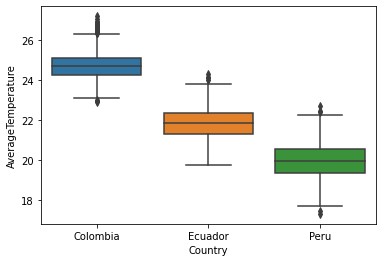

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

dados_3_paises = df_pais[df_pais['Country'].isin(['Colombia', 'Peru', 'Ecuador'])]

# Removendo duas colunas e categorias desnecessárias
dados_3_paises.drop(columns=['AverageTemperatureUncertainty', 'dt'], axis=1, inplace=True)
dados_3_paises.Country.cat.remove_unused_categories(inplace=True)

sns.boxplot(x="Country", y="AverageTemperature", data=dados_3_paises)

plt.show()

### Resultado
Como esperado, vemos que as temperaturas do Equador estão entre 
as temperaturas da Colombia e Peru, <br>com maior proximidade as 
temperaturas do Peru. <br> Também podemos observar que há muitos 
outliers para temperatura máxima no gráfico da Colômbia.<br>Não há 
outliers para temperatura mínina no Ecuador. <br>Temos muitos outliers para maiores temperaturas na Colômbia. <br>Temos alguns poucos outliers tanto
para mínimo como para máximo para o Peru. 

### Distribuição gaussiana e Outliers
Temos noção prévia que existem outliers no dataset da Colômbia, mas vamos ver quanto isso interfere no gráfico gaussiano, plottamos para ver se a distribuição está no "formato de sino" correto.



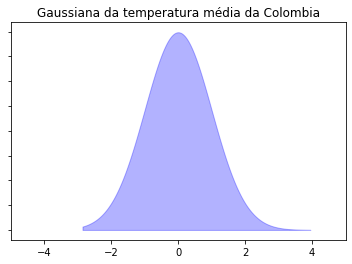

In [23]:
from scipy.stats import norm
# Biblioteca de normalização

med_colombia = colombia['AverageTemperature'].mean()
max_colombia = colombia['AverageTemperature'].max()
min_colombia = colombia['AverageTemperature'].min()
z1, z2 = (min_colombia - med_colombia)/colombia['AverageTemperature'].std(), (max_colombia - med_colombia)/colombia['AverageTemperature'].std()

range_colombia = np.arange(z1, z2, 0.001)

# pdf = funcao de densidade
y = norm.pdf(range_colombia,0,1)

fig, ax = plt.subplots()

ax.fill_between(range_colombia,y,0, alpha=0.3, color='b')
# Range de -5, 5 no eixo x
ax.set_xlim([-5,5])
# Inibir eixo y
ax.set_yticklabels([])
ax.set_title('Gaussiana da temperatura média da Colombia')

plt.show()

### Análise do gráfico
Podemos ver que apesar do gráfico ter valores mais tendenciosos ao eixo x positivo. Isso já era esperado, dado que vimos anteriormente no gráfico de barras que ele tinha muitos valores acima da média. Ainda assim, esse gráfico segue bastante o formato de um sino, que é o formato que representa uma distribuição gaussiana. Vamos agora dar atenção aos outliers.

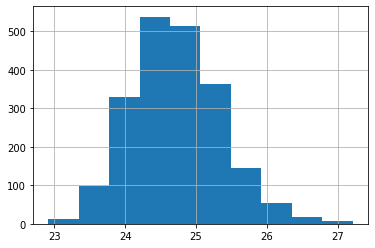

In [24]:
# Visualizamos um gráfico idêntico ao de cima, desta vez com os valores reais
colombia['AverageTemperature'].hist()

### Remoção de outliers

Aqui iremos utilizar da normalização e correlação de Pearson para "acusar" dados de serem outliers. Depois iremos remover com base nos gráficos de caixa, usando como referência os quartis.

In [25]:
from scipy import stats
from scipy.stats import norm
col_nao_nulos = colombia[(colombia['AverageTemperature'].notna()) & (colombia['AverageTemperatureUncertainty'].notna())]
k1 = col_nao_nulos['AverageTemperature'].to_numpy()
k2 = col_nao_nulos['AverageTemperatureUncertainty'].to_numpy()
# Transformando 2 arrays 1-D em array bidimencional
col_nao_nulos = np.column_stack((k1, k2))

In [26]:
# Normalizando o array
from sklearn.preprocessing import StandardScaler
ss_scaler = StandardScaler()
ss_scaler.fit(col_nao_nulos)
StandardScaler()

StandardScaler(copy=True, with_mean=True, with_std=True)

In [27]:
# Procurando correlação usando os dados normalizados
from scipy.stats import pearsonr
print(pearsonr(k1, k2))
k1, k2 = None, None

(-0.39961295506975103, 1.7635365229953268e-80)


### Correlação de Pearson
Identificamos uma correlação negativa fraca, ou seja, temos poucos dados que tem seu crescimento inversamente proporcional (maiores médias de temperaturas têm menores médias de incerteza, e, menores médias de temperatura têm maiores valores de incerteza). Assim, decidimos tratar os outliers quando ambos conjuntos crescem.

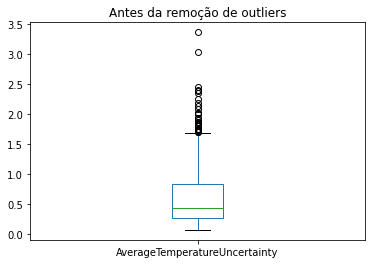

In [28]:
import matplotlib.pyplot as plt
colombia['AverageTemperatureUncertainty'].plot.box(title='Antes da remoção de outliers')

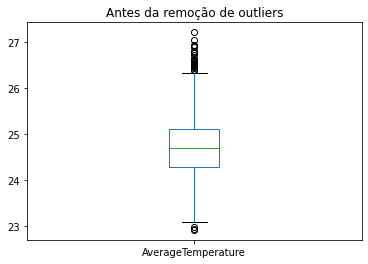

In [29]:
colombia['AverageTemperature'].plot.box(title='Antes da remoção de outliers')

In [30]:
# Usamos os quartis para encontrar os whiskers superiores
iqr_colombia = [colombia['AverageTemperature'].quantile(.75) - colombia['AverageTemperature'].quantile(.25), 
                colombia['AverageTemperatureUncertainty'].quantile(.75) - colombia['AverageTemperatureUncertainty'].quantile(.25)]
max_interval = [colombia['AverageTemperature'].quantile(.75) + 1.5*iqr_colombia[0], 
                colombia['AverageTemperatureUncertainty'].quantile(.75) + 1.5*iqr_colombia[1]]

print('Valores de whisker superior:', max_interval)

Valores de whisker superior: [26.366500000000002, 1.698]


In [31]:
# Removemos usando como base os valores de whisker encontrados acima
col_outliers = colombia[(colombia['AverageTemperature'] > max_interval[0]) | (colombia['AverageTemperatureUncertainty'] > max_interval[1])]
print(len(col_outliers))
col_outliers.head(len(col_outliers)//2)

55


,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Ano,Mes,Dia
114733,1824-02-01,24.709,1.802,Colombia,1824,2,1
114738,1824-07-01,24.975,2.395,Colombia,1824,7,1
114743,1824-12-01,26.012,1.855,Colombia,1824,12,1
114744,1825-01-01,25.583,1.736,Colombia,1825,1,1
114747,1825-04-01,25.533,1.746,Colombia,1825,4,1
114750,1825-07-01,24.431,1.871,Colombia,1825,7,1
114751,1825-08-01,24.244,1.746,Colombia,1825,8,1
114759,1826-04-01,24.690,1.870,Colombia,1826,4,1
114767,1826-12-01,25.979,1.819,Colombia,1826,12,1
114768,1827-01-01,26.168,2.027,Colombia,1827,1,1


In [32]:
# Negamos as condicionais usadas para encontrar outliers e 
# verificamos que continuamos com uma quantidade boa de valores sem outliers
col_sem_outliers = colombia[(colombia['AverageTemperature'] <= max_interval[0]) & (colombia['AverageTemperatureUncertainty'] <= max_interval[1])]
print(len(col_sem_outliers), len(colombia))

2022 2277


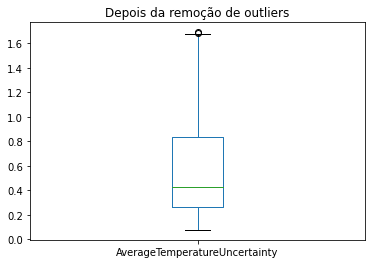

In [33]:
col_sem_outliers['AverageTemperatureUncertainty'].plot.box(title='Depois da remoção de outliers')

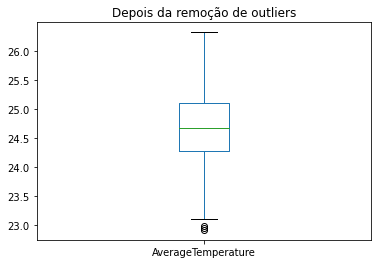

In [34]:
col_sem_outliers['AverageTemperature'].plot.box(title='Depois da remoção de outliers')

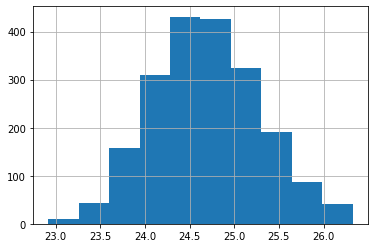

In [35]:
col_sem_outliers['AverageTemperature'].hist()

### Conclusão
O gráfico acima está com dados mais bem distribuídos, como era esperado agora o histograma está mais semelhante a uma distribuição gaussiana e o gráfico de caixa demonstra a mesma coisa: eliminamos com sucesso os outliers.

## Discretização 
Normalmente, temos 4 estações (na América do Sul mais ou menos definidas), decidi então dividir usando o 4-percentil com isso podemos ver se as diferenças climáticas no Equador são grandes ou não. Usaremos discretização apenas para verificar isto.

In [36]:
# Para garantir que não há dados faltando nos quartis,
# uso o Data-Frame anteriormente preenchido com a média de temps
equador['Discretizado'] = pd.qcut(equador['AverageTemperature'], 4)
equador['Discretizado']

151133    (19.767999999999997, 21.397]
151134                (21.397, 21.991]
151135                (21.397, 21.991]
151136                (22.606, 24.336]
151137    (19.767999999999997, 21.397]
                      ...             
152899                (21.991, 22.606]
152900                (21.397, 21.991]
152901    (19.767999999999997, 21.397]
152902                (21.397, 21.991]
152903                (22.606, 24.336]
Name: Discretizado, Length: 1771, dtype: category
Categories (4, interval[float64]): [(19.767999999999997, 21.397] < (21.397, 21.991] < (21.991, 22.606] <
                                    (22.606, 24.336]]

In [37]:
equador['AverageTemperature'].quantile(0.75)-equador['AverageTemperature'].quantile(0.25)

1.208999999999996

#### Resultado da análise
A partir do que foi observado acima, podemos perceber que 
o Equador tem temperaturas que variam entre 19.76°C e 24.33°C.
A diferença dos valores no 2-quartil e 3-quartil é bastante pequena (< 1.5°C),
logo, podemos dizer que o Equador possui um clima estável durante a maior parte do ano.


## Atualidades: Pantanal em Chamas 🔥️

Um assunto bastante comentado durante a realização do trabalho é a situação das queimadas na Região Centro-Oeste. Com dados de cidades da região, prentendemos ver quais meses são os meses mais quentes e ver se encontramos algum padrão.
Verificamos também se há quantidade semelhante de dados entre os datasets.

In [38]:
# Tratando dataset de cidades antes de usá-lo
df_cidade = pd.read_csv('/content/IF697-Projeto-Data-Science/datasets/GlobalLandTemperaturesByCity.csv')
df_cidade['City']    = df_cidade['City'].astype('category')
df_cidade['Country'] = df_cidade['Country'].astype('category')
df_cidade['AverageTemperature'] = df_cidade['AverageTemperature'].astype('float')
df_cidade['AverageTemperatureUncertainty'] = df_cidade['AverageTemperatureUncertainty'].astype('float')
df_cidade['Latitude'] = df_cidade['Latitude'].astype('object')
df_cidade['Longitude'] = df_cidade['Longitude'].astype('object')
df_cidade['dt']      = pd.to_datetime(df_cidade['dt'], format='%Y-%m-%d').astype('datetime64')

In [39]:
cuiaba = campo_grande = goiania = pd.DataFrame()

if ('Cuiabá' in df_cidade['City'].cat.categories):
  cuiaba       = df_cidade[df_cidade['City'] == 'Cuiabá']

if ('Campo Grande' in df_cidade['City'].cat.categories):
  campo_grande = df_cidade[df_cidade['City'] == 'Campo Grande']

if ('Goiânia' in df_cidade['City'].cat.categories):
  goiania      = df_cidade[df_cidade['City'] == 'Goiânia']

print(len(cuiaba), len(campo_grande), len(goiania))

2181 2181 2181


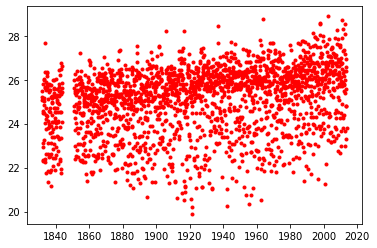

In [40]:
plt.plot(cuiaba['dt'], cuiaba['AverageTemperature'], 'r.')
plt.show()

### Usando KNN para imputação
 Vamos usar o KNN para preencher valores inexistentes do gráfico. <br> 
 Temos a expectativa de encontrar uma nuvem de pontos vermelhos que continue
 crescente entre a parte esquerda e a parte direita do gráfico.
 Considerando que existem poucos dados faltando, posso colocar um K = 5.

In [41]:
cuiaba_reshape = cuiaba[:len(cuiaba)-9]
# Temos que remover os últimos 9 meses, dado que o ano de 2013 não está completo

In [42]:
# Dividindo array
cuiaba_reshape = np.array(cuiaba_reshape['AverageTemperature'].values)
cuiaba_reshape = cuiaba_reshape.reshape(12, 181)

In [43]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from fancyimpute import KNN
# Jupyter apresenta aviso sobre a versão do módulo sklearn
# para melhor legibilidade, suprimimos o aviso

cuiaba_knn = KNN(k=5).fit_transform(cuiaba_reshape)
cuiaba_knn.shape

cuiaba_knn_plot = cuiaba_knn.reshape(2172)

Imputing row 1/12 with 37 missing, elapsed time: 0.001


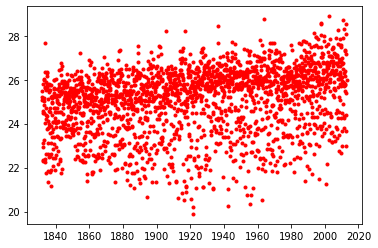

In [44]:
plt.plot(cuiaba['dt'][:len(cuiaba)-9], cuiaba_knn_plot, 'r.')
plt.show()

#### Conclusão

Podemos ver que ao usar um KNN com K = 5 houve grande uma aglutinação dos dados imputados, o que é lógico, dado que ele busca adequar a imputação aos valores mais próximos, logo temos uma tendência menor a outliers ou valores extremos.

### Ajustes pontuais
Como visto no gráfico acima, temos um vazio de informação entre os anos de 1840 e 1860, como não é de nosso interesse buscar por dados tão antigos, vamos pegar dados dos últimos 10 anos. Escolhemos um intervalo consideravelmente menor, pois os dados são mensais. É interessante perceber também que as temperaturas no passado poucas vezes ultrapassam a marcação de 26 graus Celsius, e quanto mais avançamos os anos isso se torna uma comum, e temperaturas mais baixas tornam-se mais raras.

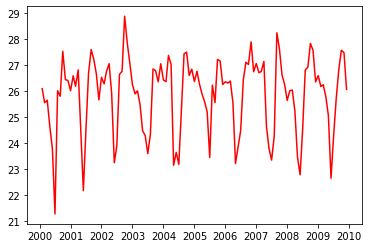

In [45]:
seg_graf_cuiaba = cuiaba[(cuiaba['dt'] > '2000-01-01') & (cuiaba['dt'] < '2010-01-01')]

plt.plot(seg_graf_cuiaba['dt'], seg_graf_cuiaba['AverageTemperature'], 'r-')
plt.show()

**2000 a 2010**

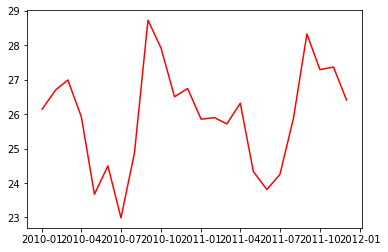

In [46]:
cuiaba2010to2012 = cuiaba
cuiaba2010to2012['Ano'] = pd.DatetimeIndex(cuiaba2010to2012['dt']).year
cuiaba2010to2012 = cuiaba2010to2012[(cuiaba2010to2012['Ano'] >= 2010) & (cuiaba2010to2012['Ano'] <= 2011)]
plt.plot(cuiaba2010to2012['dt'][:len(cuiaba2010to2012)], cuiaba2010to2012['AverageTemperature'], 'r-')
plt.show()

**2010 a 2012**

### Análise
Ao trocar o tipo de gráfico, agora temos como visualizar mais facilmente:
Cuiabá passa por uma queda abrupta de temperatura que é imediatamente seguida por um pico de temperatura, aproximadamente entre Julho e Setembro. Mas, como não sabemos exatamente quando isso ocorre, podemos procurar um padrão, dessa vez usando Goiânia e Campo Grande no mesmo gráfico.

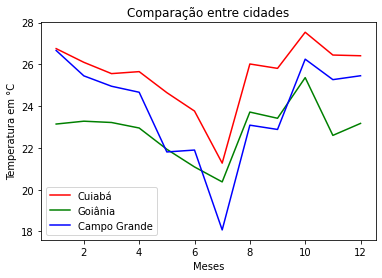

In [47]:
ter_graf_cuiaba = cuiaba[(cuiaba['dt'] > '1999-12-01') & (cuiaba['dt'] < '2001-01-01')]
pri_graf_goiania = goiania[(goiania['dt'] > '1999-12-01') & (goiania['dt'] < '2001-01-01')]
pri_graf_campo_grande = campo_grande[(campo_grande['dt'] > '1999-12-01') & (campo_grande['dt'] < '2001-01-01')]

meses = np.arange(1,13,1)

plt.plot(meses, ter_graf_cuiaba['AverageTemperature'], 'r-', label='Cuiabá') 
plt.plot(meses, pri_graf_goiania['AverageTemperature'], 'g-', label='Goiânia')
plt.plot(meses, pri_graf_campo_grande['AverageTemperature'], 'b-', label='Campo Grande')

plt.legend()
plt.ylabel('Temperatura em °C')
plt.xlabel('Meses')
plt.title('Comparação entre cidades')
plt.show()

### Resultado
Percebemos que as três cidades tem um padrão bastante comum. Todas possuem menores temperaturas no mês de julho e maiores temperaturas no mês de outubro.
Por coincidência, no momento de escrita desse projeto, estamos no mês de outubro, então podemos esperar que essa situação de alta de temperatura se agrave em 2020.

### Confirmação

Agora dado que sabemos que o clima das 3 capitais do Centro-Oeste são semelhantes, então podemos analisar Cuiabá tendo mais certeza que os dados não estão distantes da realidade. Vamos verificar os dados das últimas 5 décadas para ter um panorama melhor do clima cuiabense. 

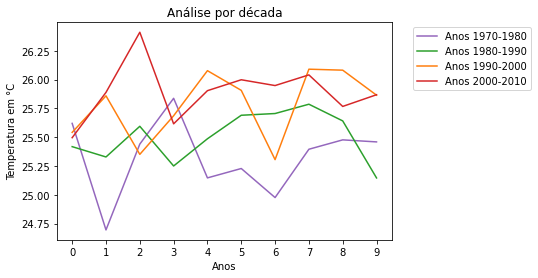

In [48]:
dez = np.arange(0,10,1)

# Vamos plotar um gráfico que contenha dados das últimas 4 décadas de Cuiabá

np_cidade = cuiaba[(cuiaba['dt'] > '1969-12-01') & (cuiaba['dt'] < '1980-01-01')]['AverageTemperature'].to_numpy()
rs_cidade = np_cidade.reshape(10,12)
# mean_cidade = [c.mean() for c in rs_cidade]
mean_cidade = list(map(lambda x: sc.parallelize(x).reduce(lambda a,b: a+b)/len(x), rs_cidade))
plt.plot(dez, mean_cidade, 'C4-', label='Anos 1970-1980')

np_cidade = cuiaba[(cuiaba['dt'] > '1979-12-01') & (cuiaba['dt'] < '1990-01-01')]['AverageTemperature'].to_numpy()
rs_cidade = np_cidade.reshape(10,12)
# mean_cidade = [c.mean() for c in rs_cidade]
mean_cidade = list(map(lambda x: sc.parallelize(x).reduce(lambda a,b: a+b)/len(x), rs_cidade))
plt.plot(dez, mean_cidade, 'C2-', label='Anos 1980-1990')

np_cidade = cuiaba[(cuiaba['dt'] > '1989-12-01') & (cuiaba['dt'] < '2000-01-01')]['AverageTemperature'].to_numpy()
rs_cidade = np_cidade.reshape(10,12)
# mean_cidade = [c.mean() for c in rs_cidade]
mean_cidade = list(map(lambda x: sc.parallelize(x).reduce(lambda a,b: a+b)/len(x), rs_cidade))
plt.plot(dez, mean_cidade, 'C1-', label='Anos 1990-2000')

np_cidade = cuiaba[(cuiaba['dt'] > '1999-12-01') & (cuiaba['dt'] < '2010-01-01')]['AverageTemperature'].to_numpy()
rs_cidade = np_cidade.reshape(10,12)
# mean_cidade = [c.mean() for c in rs_cidade]
mean_cidade = list(map(lambda x: sc.parallelize(x).reduce(lambda a,b: a+b)/len(x), rs_cidade))
plt.plot(dez, mean_cidade, 'C3-', label='Anos 2000-2010')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Análise por década')
plt.ylabel('Temperatura em °C')
plt.xlabel('Anos')
plt.xticks(np.arange(0, 10, 1))
plt.show()

### Análise da década

Vemos que os últimos 20 anos (linha vermelha e amarela) sem dúvidas foram os mais quentes, apesar disso, a temperatura de Cuiabá segue com média anual entre 24 e 27 graus. Ao compararmos intercalando as décadas em pares, é possível perceber que há décadas mais amenas (linhas verde e vermelha) e décadas com clima mais instável (linha roxa e amarela). Caso isso se confirme, é provável que a década 2020-2030 tenha clima mais instável, essa informação traduzida ao mundo real pode se concretizar na forma de secas/inundações acentuadas.

## Comparando regiões

Vimos acima três cidade centrais no Brasil. Vamos analisar dessa vez três cidades litorâneas do Nordeste nos ultimos 20 anos, podemos fazer uma comparação das médias do litoral do Nordeste com o Centro-Oeste do Brasil.

In [49]:
natal = recife = aracaju = pd.DataFrame()

if ('Recife' in df_cidade['City'].cat.categories):
  recife = df_cidade[df_cidade['City'] == 'Recife']
if ('Natal' in df_cidade['City'].cat.categories):
  natal = df_cidade[df_cidade['City'] == 'Natal']
if ('Aracaju' in df_cidade['City'].cat.categories):
  aracaju = df_cidade[df_cidade['City'] == 'Aracaju']

print(len(natal), len(recife), len(aracaju))

1953 2181 2181


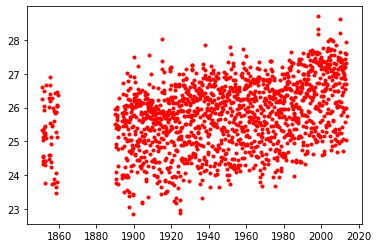

In [50]:
plt.plot(natal['dt'][:len(natal)], natal['AverageTemperature'], 'r.')
plt.show()

Como pretendemos focar nos últimos 20 anos, a falta de dados dos anos 1860 a 1890 em Natal não vai influenciar na análise.

### Gráfico das Médias
Com a média de seis Cidades num período de 20 anos (1990-2010).

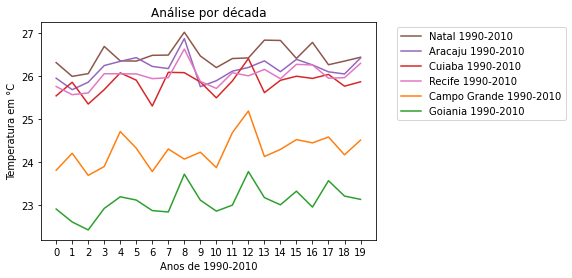

In [51]:
vinte = np.arange(0,20,1)

np_cidade = natal[(natal['dt'] > '1989-12-01') & (natal['dt'] < '2010-01-01')]['AverageTemperature'].to_numpy()
rs_cidade = np_cidade.reshape(20,12)
mean_natal = list(map(lambda x: sc.parallelize(x).reduce(lambda a,b: a+b)/len(x), rs_cidade))
plt.plot(vinte, mean_natal, 'C5-', label='Natal 1990-2010')

np_cidade = aracaju[(aracaju['dt'] > '1989-12-01') & (aracaju['dt'] < '2010-01-01')]['AverageTemperature'].to_numpy()
rs_cidade = np_cidade.reshape(20,12)
mean_aracaju = list(map(lambda x: sc.parallelize(x).reduce(lambda a,b: a+b)/len(x), rs_cidade))
plt.plot(vinte, mean_aracaju, 'C4-', label='Aracaju 1990-2010')

np_cidade = cuiaba[(cuiaba['dt'] > '1989-12-01') & (cuiaba['dt'] < '2010-01-01')]['AverageTemperature'].to_numpy()
rs_cidade = np_cidade.reshape(20,12)
mean_cuiaba = list(map(lambda x: sc.parallelize(x).reduce(lambda a,b: a+b)/len(x), rs_cidade))
plt.plot(vinte, mean_cuiaba, 'C3-', label='Cuiaba 1990-2010')

np_cidade = recife[(recife['dt'] > '1989-12-01') & (recife['dt'] < '2010-01-01')]['AverageTemperature'].to_numpy()
rs_cidade = np_cidade.reshape(20,12)
mean_recife = list(map(lambda x: sc.parallelize(x).reduce(lambda a,b: a+b)/len(x), rs_cidade))
plt.plot(vinte, mean_recife, 'C6-', label='Recife 1990-2010')

np_cidade = campo_grande[(campo_grande['dt'] > '1989-12-01') & (campo_grande['dt'] < '2010-01-01')]['AverageTemperature'].to_numpy()
rs_cidade = np_cidade.reshape(20,12)
mean_campo_grande = list(map(lambda x: sc.parallelize(x).reduce(lambda a,b: a+b)/len(x), rs_cidade))
plt.plot(vinte, mean_campo_grande, 'C1-', label='Campo Grande 1990-2010')

np_cidade = goiania[(goiania['dt'] > '1989-12-01') & (goiania['dt'] < '2010-01-01')]['AverageTemperature'].to_numpy()
rs_cidade = np_cidade.reshape(20,12)
mean_goiania = list(map(lambda x: sc.parallelize(x).reduce(lambda a,b: a+b)/len(x), rs_cidade))
plt.plot(vinte, mean_goiania, 'C2-', label='Goiania 1990-2010')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Análise por década')
plt.ylabel('Temperatura em °C')
plt.xlabel('Anos de 1990-2010')
plt.xticks(np.arange(0, 20, 1))
plt.show()

Vemos que existe uma diferença nas médias por ano dos estados do Nordeste e Centro-Oeste, porém a temperatura em Cuiabá ainda se aproxima muito das médias no Nordeste.
Podemos ver isso calculando a média por ano das três cidade nordestinas.

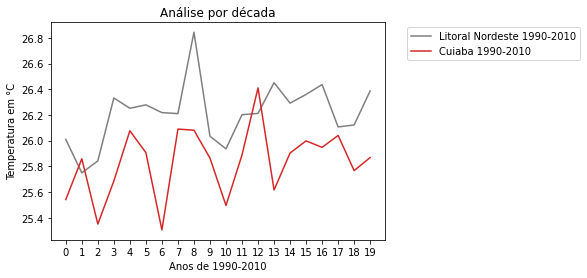

In [52]:
nordeste_par = sc.parallelize(np.array([mean_recife, mean_natal, mean_aracaju]))
# Como temos 3 listas seguidas no array,
# usamos reduce para somar os elementos na mesma posicao de cada lista
medias_nordeste = nordeste_par.reduce(lambda x, y: x+y)/len(nordeste_par.collect())
# Ou seja, calculamos as medias por "coluna" no vetor

plt.plot(vinte, medias_nordeste, 'C7-', label='Litoral Nordeste 1990-2010')
plt.plot(vinte, mean_cuiaba, 'C3-', label='Cuiaba 1990-2010')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Análise por década')
plt.ylabel('Temperatura em °C')
plt.xlabel('Anos de 1990-2010')
plt.xticks(np.arange(0, 20, 1))
plt.show()

### Nordeste e Centro-Oeste
Vamos ver agora o que acontece quando comparamos a média das três cidades nordestinas com a dos três do Centro-Oeste.

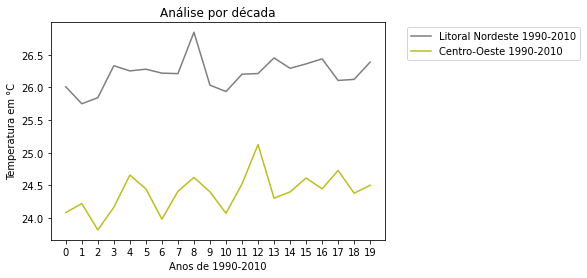

In [53]:
centro_oeste_par = sc.parallelize(np.array([mean_cuiaba, mean_campo_grande, mean_goiania]))
medias_centro_oeste = centro_oeste_par.reduce(lambda x, y: x+y)/len(centro_oeste_par.collect())

plt.plot(vinte, medias_nordeste, 'C7-', label='Litoral Nordeste 1990-2010')
plt.plot(vinte, medias_centro_oeste, 'C8-', label='Centro-Oeste 1990-2010')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Análise por década')
plt.ylabel('Temperatura em °C')
plt.xlabel('Anos de 1990-2010')
plt.xticks(np.arange(0, 20, 1))
plt.show()

Podemos provar que as médias no Litoral nordestido são sempre mais altas que as médias no Centro-Oeste do Brasil.

## Normalização dos dados

Dado que nossos dados estão num range pequeno em torno de X e Y
utilizamos da ferramenta de normalização MinMax do Scikitlearn 
para fazer a normalização e ver por uma última vez como a temperatura em Cuiabá varia drasticamente.

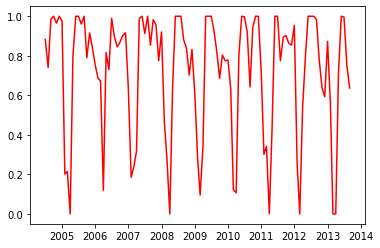

In [54]:
# Normalizando usando min-max do scikit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
MinMax_scaler = MinMaxScaler()

cuiaba_minmaxscaler = MinMax_scaler.fit_transform(cuiaba_knn)

# Para melhor precisão, diminuo o escopo para últimos 10 anos
cuiaba_minmaxscaler_reshape = cuiaba_minmaxscaler.reshape(2172)
cuiaba_minmaxscaler_reshape = cuiaba_minmaxscaler_reshape[len(cuiaba)-(10*12):]
plt.plot(cuiaba['dt'][len(cuiaba)-((10*12)-9):], cuiaba_minmaxscaler_reshape, 'r-')

### Aquecimento Global
Podemos ver quais paises foram mais afetados pelo aquecimento global atráves da diferenciação das suas temperaturas habituais para termos uma ideia.

In [55]:
SA_paises = set(['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela'])
SA_aquecimento = df_pais[df_pais['Country'].isin(SA_paises)]

gp_SA_aquecimento = pd.DataFrame(SA_aquecimento.groupby('Country', group_keys=False, as_index=False)['AverageTemperature'].mean())
gp_SA_aquecimento = gp_SA_aquecimento[gp_SA_aquecimento['AverageTemperature'].isnull() == False]

gp_SA_aquecimento['Country'].cat.remove_unused_categories(inplace=True)
SA_aquecimento['Country'].cat.remove_unused_categories(inplace=True)

dicio_SA = {}
for k in range(0,12):
  dicio_SA[gp_SA_aquecimento['Country'].values[k]] = gp_SA_aquecimento['AverageTemperature'].values[k]

In [56]:
# Precisamos preencher as médias, só que precisamos colocar as médias
# respectivas a cada país. Então salvamos os dados NA num DF a parte
# depois removemos os NA do principal,
# para então aplicar uma função que preencha os NA
# de acordo com o país.
nulos = SA_aquecimento[SA_aquecimento['AverageTemperature'].isnull()]
SA_aquecimento['AverageTemperature'].dropna(inplace=True)


In [57]:
nulos['AverageTemperature'] = nulos['Country'].apply(lambda p: dicio_SA[p])
nulos

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Ano,Mes,Dia
27366,2013-09-01,14.621194,NaN,Argentina,2013,9,1
69712,2013-09-01,20.877231,NaN,Bolivia,2013,9,1
77254,1844-01-01,24.699256,NaN,Brazil,1844,1,1
77255,1844-02-01,24.699256,NaN,Brazil,1844,2,1
77256,1844-03-01,24.699256,NaN,Brazil,1844,3,1
...,...,...,...,...,...,...,...
562590,1844-12-01,25.025686,NaN,Venezuela,1844,12,1
562600,1845-10-01,25.025686,NaN,Venezuela,1845,10,1
562601,1845-11-01,25.025686,NaN,Venezuela,1845,11,1
562602,1845-12-01,25.025686,NaN,Venezuela,1845,12,1


In [58]:
SA_aquecimento['AverageTemperature'].dropna(inplace=True)

In [59]:
nulos['AverageTemperature'] = nulos['Country'].apply(lambda p: dicio_SA[p])
nulos

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Ano,Mes,Dia
27366,2013-09-01,14.621194,NaN,Argentina,2013,9,1
69712,2013-09-01,20.877231,NaN,Bolivia,2013,9,1
77254,1844-01-01,24.699256,NaN,Brazil,1844,1,1
77255,1844-02-01,24.699256,NaN,Brazil,1844,2,1
77256,1844-03-01,24.699256,NaN,Brazil,1844,3,1
...,...,...,...,...,...,...,...
562590,1844-12-01,25.025686,NaN,Venezuela,1844,12,1
562600,1845-10-01,25.025686,NaN,Venezuela,1845,10,1
562601,1845-11-01,25.025686,NaN,Venezuela,1845,11,1
562602,1845-12-01,25.025686,NaN,Venezuela,1845,12,1


In [60]:
SA_aquecimento = SA_aquecimento.append(nulos)
SA_aquecimento['AverageTemperature']

25466     10.745000
25467      6.995000
25468      6.901000
25469      9.097000
25470     11.316000
            ...    
562590    25.025686
562600    25.025686
562601    25.025686
562602    25.025686
564615    25.025686
Name: AverageTemperature, Length: 26501, dtype: float64

In [61]:
# classificar anos mais quentes e anos mais frios e ver se posso confirmar: 
# anos mais frios estão mai s distantes e anos mais quentes estão mais pertos
br_anos = SA_aquecimento[SA_aquecimento['Country']=='Brazil'].groupby('Ano')['AverageTemperature'].sum()

In [62]:
br_anos = br_anos.sort_values(inplace=False)

# Removendo o ano de 2013 que está incompleto e ainda está no data-frame
br_anos = br_anos[1:len(br_anos)]
br_anos = br_anos.to_frame()
br_anos = br_anos.reset_index(col_level=[[]])

In [63]:
print('10 anos mais frios no Brasil (começando em 1832):')
frio = br_anos.copy()
frio['AverageTemperature'] = frio['AverageTemperature']/12
frio.head(10)

10 anos mais frios no Brasil (começando em 1832):


,Ano,AverageTemperature
0,1835,23.537500
1,1837,23.608917
2,1838,23.726917
3,1917,23.797500
4,1839,23.804000
5,1832,23.858583
6,1893,23.910583
7,1875,23.913250
8,1836,23.921167
9,1862,23.924250


### Comentário
Podemos verificar que apenas um ano da tabela dos mais frio pertence ao século 20, e nenhum ao século 21. Todos os outros anos mais frios pertecem ao século 19.

In [64]:
print('Os 10 anos mais quentes no Brasil (até 2012):')
quente = br_anos.copy()
quente['AverageTemperature'] = quente['AverageTemperature']/12
quente.tail(10)

Os 10 anos mais quentes no Brasil (até 2012):


,Ano,AverageTemperature
171,1997,25.559417
172,1987,25.563417
173,2009,25.600583
174,2003,25.621000
175,2007,25.668000
176,2012,25.717083
177,2002,25.800333
178,2005,25.806000
179,2010,25.812417
180,1998,25.958750


### Análise do aquecimento global brasileiro

Podemos verificar que no nosso top-10, há 3 anos do século 20, sendo um destes inclusive o mais quente; e todos os outros são do século 21. Ao compararmos as duas tabelas acima, percebemos que há uma distância média de 2 graus Celsius entre as médias dos anos mais quentes e os mais frios. Abaixo vamos comprovar que houve um aumento. Plottamos um gráfico que mostra mensalmente as temperaturas médias brasileiras, os pontos vermelhos são meses depois da década de 80, os pontos azuis antes da década de 80.

In [65]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_pais[df_pais['Country'] == 'Brazil']['Mes'],
    y=df_pais[df_pais['Country'] == 'Brazil']['AverageTemperature'],
    mode='markers',
    marker=dict(
        size=5,
        color=(
            (df_pais[df_pais['Country'] == 'Brazil']['Ano'] < 1980) &
            (df_pais[df_pais['Country'] == 'Brazil']['Ano'] <= 1980)
        ).astype('float'),
        colorscale=[[0, 'red'], [1, 'blue']]
    )
)
)

fig.show()

### Lugares mais quentes do mundo
Dado que anteriormente vimos que o Brasil está esquentando, vamos agora utilizar do data-set de países para ver quais os lugares mais quentes se mantém quentes.

In [66]:
# Vamos ver os 20 países mais quentes e frios do mundo
p_quente_frio = df_pais.groupby('Country')['AverageTemperature'].mean()

In [67]:
p_quente_frio = p_quente_frio.sort_values()
p_quente_frio = p_quente_frio[:-1]

In [68]:
p_quente_frio.head(20)

Country
Greenland                                   -18.587458
Denmark                                     -18.053051
Svalbard And Jan Mayen                       -7.448028
Russia                                       -5.521882
Canada                                       -5.216659
Mongolia                                     -0.820671
Norway                                        0.095804
Finland                                       1.244742
South Georgia And The South Sandwich Isla     1.401025
Iceland                                       1.405065
North America                                 2.028374
Sweden                                        2.386332
Heard Island And Mcdonald Islands             2.562115
Kyrgyzstan                                    3.220498
Tajikistan                                    4.016035
Saint Pierre And Miquelon                     4.223060
Liechtenstein                                 4.642939
Estonia                                       4.819806
Fr

In [69]:
p_quente_frio.tail(20)

Country
Sri Lanka                            26.947687
Guam                                 26.996834
Northern Mariana Islands             26.996834
Sudan                                27.093359
Chad                                 27.120466
Kingman Reef                         27.133034
Palmyra Atoll                        27.163456
Benin                                27.171999
Bonaire, Saint Eustatius And Saba    27.173295
Palau                                27.216379
Curaçao                              27.353415
Niger                                27.458973
Gambia                               27.538552
Mauritania                           27.620256
United Arab Emirates                 27.693995
Aruba                                27.920390
Senegal                              27.967375
Burkina Faso                         28.083507
Mali                                 28.441977
Djibouti                             28.816603
Name: AverageTemperature, dtype: float64

In [70]:
mais_quentes = df_pais.sort_values(by='AverageTemperature').dropna()
mais_quentes.reset_index(inplace=True, drop=True)

# Vamos dividir arbitrariamente no meio o dataset e 
# ver as quantidades de paises que tem aparecido mais nos mais quentes
mais_quentes = mais_quentes[int(len(mais_quentes)/2):len(mais_quentes)]

In [71]:
print(len(df_pais['Country'].unique()),' versus ',len(mais_quentes['Country'].unique()))

243  versus  210


### Indução
Por indução temos que a temperatura da Terra não deve ser seguir uma distribuição gaussiana, dado que os nosso dataframe segue divisões políticas é de se imaginar que por isso existam muitos dados "inibidos". Por exemplo, temos países frios como Rússia e Canadá, ambas nações territorialmente extensas e de temperaturas frias, que ao julgar por nosso dataset acabam por impactar pouco já que são apenas 2 países puxando a média para baixo. Ao passo que, no continente africano, onde as temperaturas são bastante elevadas, temos dezenas de nações que elevam as médias de temperatura do nosso dataset. Estes dados poderiam ser considerados como "enviesados" já que possuímos mais dados de países quentes.

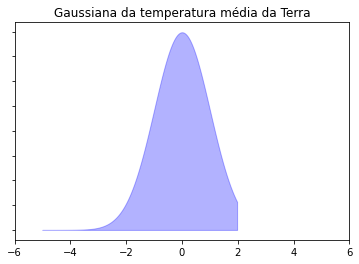

In [72]:
med_pais = df_pais['AverageTemperature'].mean()
max_pais = df_pais['AverageTemperature'].max()
min_pais = df_pais['AverageTemperature'].min()
z1, z2 = (min_pais - med_pais)/df_pais['AverageTemperature'].std(), (max_pais - med_pais)/df_pais['AverageTemperature'].std()

range_pais = np.arange(z1, z2, 0.001)

# pdf = funcao de densidade
y = norm.pdf(range_pais,0,1)

fig, ax = plt.subplots()

ax.fill_between(range_pais,y,0, alpha=0.3, color='b')
ax.set_xlim([-6,6])
ax.set_yticklabels([])
ax.set_title('Gaussiana da temperatura média da Terra')

plt.show()

### Conclusão
Como previsto, podemos ver que há uma tendência de mais dados indicando temperatura quente na distribuição. Esse valor crítico visivelmente não equilibrado mostra que nossa hipótese nula sobre os dados está correta.

## Parte 2


### Contextualizando
De acordo com o atual contexto político e ambiental da Terra, nós (humanos), temos um compromisso em comum de valorizar os recursos que nos são disponíveis. Visto que o recurso mais precioso para a vida em qualquer lugar do planeta foi a água na sua forma líquida que depende das condições de Temperatura e Pressão distribuída na Terra. Decidimos que para ter alguma análise de relevância e mais domínio do cenário, nessa segunda parte do projeto, daremos ênfase na região de Recife com a coluna 'AverageTemperature' que representa a temperatura média presente em todos os nossos datasets.

#### Séries Temporais
Porém, iniciaremos nossa análise entendendo o contexto geral do país. Aqui iremos utilizar média móvel para percorrer o último século completo de temperaturas no território brasileiro.

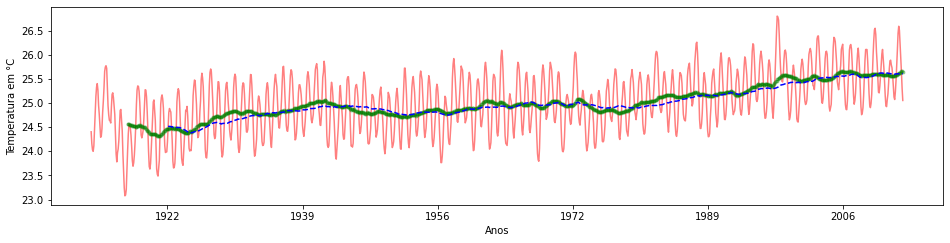

In [73]:
brasil_media_movel = df_pais[(df_pais['Country'] == 'Brazil') & (df_pais['dt'] > datetime(1912, 12, 31))]
brasil_media_movel = brasil_media_movel.drop(labels=['Country', 'AverageTemperatureUncertainty'], axis=1)
fig1 = plt.figure(figsize=(16, 8))
janelas_3 = [brasil_media_movel['AverageTemperature'].rolling(6).mean(), brasil_media_movel['AverageTemperature'].rolling(60).mean(), brasil_media_movel['AverageTemperature'].rolling(120).mean()]

# Devido a algum problema com nosso datetime, o plot apresenta os valores da coluna index
# Tentamos de diversas formas resolver mas o problema persistiu, então adicionamos o datetime forcado
plt.subplot(211, xticklabels=['0', str(brasil_media_movel.dt[78200].year),str(brasil_media_movel.dt[78400].year),str(brasil_media_movel.dt[78600].year),str(brasil_media_movel.dt[78800].year),str(brasil_media_movel.dt[79000].year),str(brasil_media_movel.dt[79200].year)], xlabel='Anos', ylabel='Temperatura em °C')

janelas_3[0].plot(label="Média móvel de 6 meses", style='r-', alpha=.5, y='6', x='dt') # 6 meses
janelas_3[1].plot(label="Média móvel de 60 meses", style='g.', alpha=.3, y='60', x='dt') # 5 anos
janelas_3[2].plot(label="Média móvel de 120 meses", style='b--', alpha=1, y='120', x='dt') # 10 anos

Separamos três linhas para cada tipo de intervalo de frequência: 6 meses (semestral), 5 anos (quinquênio) e 10 anos (decênio). Como pode-se ver, ao análisar períodos semestrais econtramos amplitudes elevadas, mas que são bastante normalizadas conforme aumentamos a largura da amplitude temporal analisada.

#### Prophet
Agora iremos alimentar 
Utilizaremos o Prophet para tentar prever o comportamento da temperatura de Recife. Alimentamos a ferramenta com dados mensais do último século.

In [74]:
from fbprophet import Prophet

In [75]:
recife_select = df_cidade[df_cidade['City'] == 'Recife'].reset_index(drop=True)
recife_select

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1832-01-01,25.973,1.568,Recife,Brazil,8.84S,34.86W
1,1832-02-01,25.793,2.082,Recife,Brazil,8.84S,34.86W
2,1832-03-01,25.985,1.619,Recife,Brazil,8.84S,34.86W
3,1832-04-01,25.233,2.123,Recife,Brazil,8.84S,34.86W
4,1832-05-01,24.303,1.725,Recife,Brazil,8.84S,34.86W
...,...,...,...,...,...,...,...
2176,2013-05-01,26.343,0.334,Recife,Brazil,8.84S,34.86W
2177,2013-06-01,25.650,0.344,Recife,Brazil,8.84S,34.86W
2178,2013-07-01,24.583,0.909,Recife,Brazil,8.84S,34.86W
2179,2013-08-01,24.484,1.296,Recife,Brazil,8.84S,34.86W


In [76]:
recife_select.drop(labels=['AverageTemperatureUncertainty', 'Country', 'City', 'Latitude', 'Longitude'], axis=1, inplace=True)
prophet_df = recife_select.copy()
prophet_df.columns = ["ds", "y"]

Previsão para os próximos 50 anos


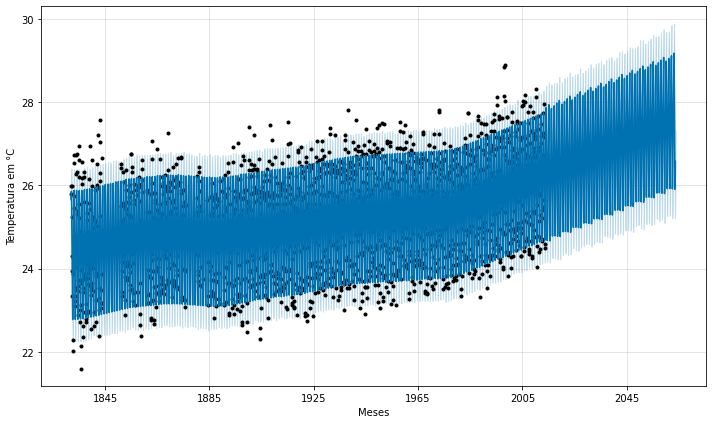

In [77]:
profeta = Prophet(weekly_seasonality=False, daily_seasonality=False)
profeta.fit(prophet_df)
pred = profeta.predict(profeta.make_future_dataframe(freq='m', periods=600))
print('Previsão para os próximos 50 anos')
profeta.plot(pred, xlabel='Meses', ylabel='Temperatura em °C');

Previsão para os próximos 100 anos


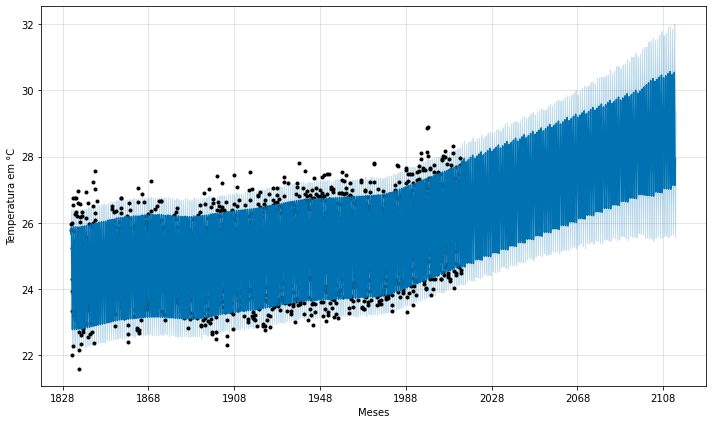

In [78]:
profeta = Prophet(weekly_seasonality=False, daily_seasonality=False)
profeta.fit(prophet_df)
print('Previsão para os próximos 100 anos')
pred = profeta.predict(profeta.make_future_dataframe(freq='m', periods=1200))
profeta.plot(pred, xlabel='Meses', ylabel='Temperatura em °C');

##### Conclusão
O resultado observado nos é estranho: no 1o gráfico, o Prophet parece apenas repetir o comportamento, ou seja, incrementar periodicamente a temperatura, a amplitude é bastante igual aos resultados prévios visualmente. No 2o gráfico, temos um pouco de variação mais perta do fim, porém não é relevante por ser algo quase que pontual. Percebemos então que por falta de dados (temos apenas temperaturas mensais) o Prophet não é de grande ajuda para nosso dataset, e por isso, os dados aparentam ser de caráter randômicos a ferramenta. Vamos usar por indicação o ARIMA. Antes, vamos verificar se a sazonalidade é um indicador forte para os dados temporais de Recife. 


##### Outros Testes Prophet
Decidimos aqui fazer outra tentativa com o Prophet em outro dataset. Podemos usar o dataset com temperaturas das terras e mares globais para ter melhor percepção de como atua o Prophet.

Temperatura média prevista para os próximos 27 anos


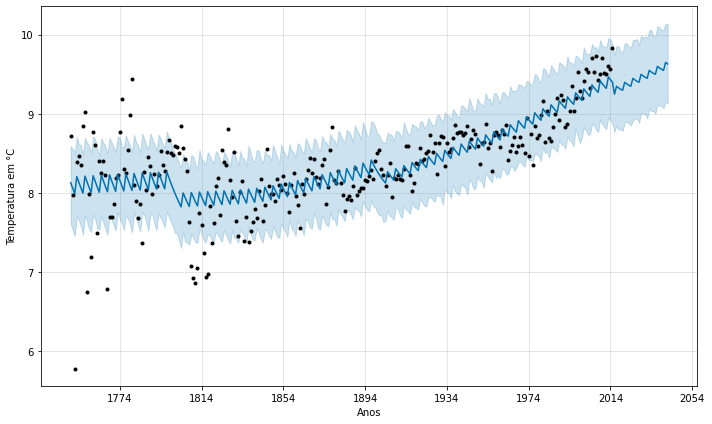

In [79]:
p = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=True)
p_data = pd.DataFrame()
global_agrupado = df_global.LandAverageTemperature.groupby(df_global.dt.dt.year)
p_data['y'] = global_agrupado.mean()
p_data['ds'] = pd.to_datetime(global_agrupado.mean().index, format='%Y')
p.fit(p_data)
futuro = p.make_future_dataframe(periods=27, freq='Y')
# Por algum problema do Prophet, para este data-set, para valores superiores a 27, ele dá int64 overflow
predicao = p.predict(futuro)
print('Temperatura média prevista para os próximos 27 anos')
p.plot(predicao, xlabel='Anos', ylabel='Temperatura em °C');

Conseguimos ter uma visão mais clara nesse caso, porém ainda se percebe uma previsão muito padronizada

#### Média mensal

Aqui fazemos a separação mensal entre as temperaturas, a seguir iremos exibir de forma sobreposta a evolução anual do último século das temperaturas de Recife.

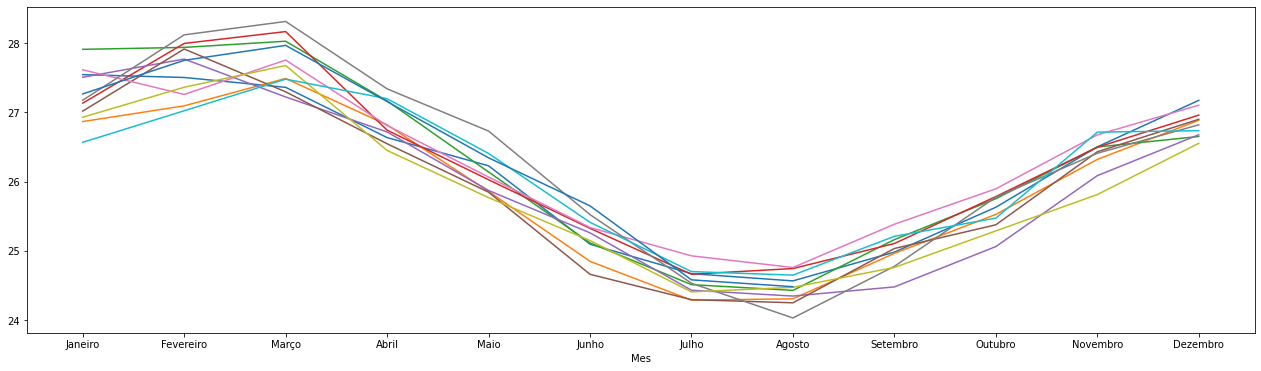

In [80]:
recife = df_cidade[df_cidade['City'] == 'Recife']

meses = [recife[recife['dt'].dt.month == x]['AverageTemperature'].dropna(axis=0) for x in range(1,13)]
min_meses = min([len(k) for k in meses])
meses = [meses[x][0:min_meses] for x in range(0,12)]

recife.set_index('dt', inplace=True)
recife = recife.loc['2003':'2013']
recife.drop(['Country', 'Latitude', 'Longitude', 'City', 'AverageTemperatureUncertainty'], axis=1, inplace=True)

recife['Mes'] = recife.index.month
recife['Ano'] = recife.index.year

pivot = pd.pivot_table(recife, values='AverageTemperature', index='Mes', columns='Ano', aggfunc='mean')
pivot.plot(figsize=(22,6))
plt.legend().remove() 
plt.xticks([x for x in range(1,13)],['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro'])
plt.show()

##### Conclusão

Os dados nos indicam que o mês influencia bastante na temperatura de Recife e visivelmente há poucos outliers. Agora que sabemos que podemos usar futuramente o S-ARIMA, ou Seasonal ARIMA para termos indicadores da temperatura da cidade.

### S-ARIMA
###### Fonte: [otexts](https://otexts.com/fpp2/seasonal-arima)

Para o Seasonal ARIMA (sigla para auto-regressivo integrado de médias móveis), temos que calcular as funções de autocorrelação (ACF) e autocorrelação parcial (PACF). Os parâmetros dados ao s-arima são: (p,d,q)(P,D,Q)m;

Temos que o nosso m = 12, pois representamos cada mês de forma distinta.
Os parâmetros P, D, Q, são relativos a parte sazonal do ARIMA, respectivamente:
* Termo de auto-regressão
* Diferenciação
* Média 
* m = Quantidade de períodos (exclusivo para modelos sazonais)

Estas definições servem também para p, d, q, sendo que estes usam os valores não-sazonais.

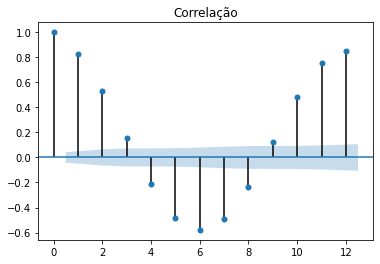

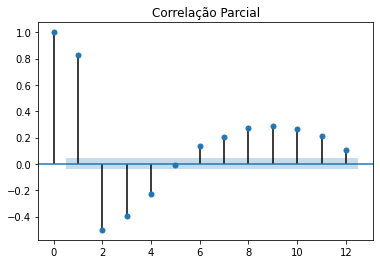

In [103]:
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

recife['AverageTemperature'] = recife['AverageTemperature'].fillna(recife['AverageTemperature'].mean())

plot_acf(title='Correlação', x=recife['AverageTemperature'].values, lags=12);
plot_pacf(title='Correlação Parcial', x=recife['AverageTemperature'].values, lags=12);

#### Análise de Autocorrelação e Correlação Parcial
É possível ver que o primeiro gráfico é bastante semelhante a uma representação cossenoidal, semelhante ao gráfico imediatamente anterior.  Isto acontece pois Recife começa o ano com temperaturas quentes e que estas estão relacionadas entre si, e vai avançando para temperaturas frias que distoam do resto do ano, voltando a crescer no fim do ano; este 1o gráfico nos indica que há um padrão. Quanto ao grau de correlação parcial, percebemos que há um pico no começo, seguido de um decréscimo e correlação baixa no fim. Isto indica que há uma alta relação entre as variáveis no começo do gráfico, logo após vão se diferenciando (correlação cai), até que por fim fiquem pouco correlacionáveis.

In [137]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX	

recife_acf = acf(recife['AverageTemperature'], nlags=12)
recife_pacf = pacf(recife['AverageTemperature'], nlags=12)

recife = df_cidade[df_cidade['City'] == 'Recife']
recife['AverageTemperature'] = recife['AverageTemperature'].dropna()

recife_SARIMAX = SARIMAX(endog=recife['AverageTemperature'], order=(0,0,0), seasonal_order=(1,1,1,12))
pred_SARIMAX = recife_SARIMAX.fit()
print(pred_SARIMAX.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



                            Statespace Model Results                            
Dep. Variable:       AverageTemperature   No. Observations:                 2181
Model:             SARIMAX(1, 1, 1, 12)   Log Likelihood               -1147.358
Date:                  Tue, 17 Nov 2020   AIC                           2300.717
Time:                          23:42:53   BIC                           2317.763
Sample:                               0   HQIC                          2306.950
                                 - 2181                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0161      0.024      0.659      0.510      -0.032       0.064
ma.S.L12      -0.8492      0.014    -61.491      0.000      -0.876      -0.822
sigma2         0.1885      0.005    

In [138]:
# Outro teste, dividindo em apenas m = 2 (verão e inverno)
recife_SARIMAX = SARIMAX(endog=recife['AverageTemperature'], order=(0,0,0), seasonal_order=(1,1,1,2))
pred_SARIMAX = recife_SARIMAX.fit()
print(pred_SARIMAX.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



                            Statespace Model Results                           
Dep. Variable:      AverageTemperature   No. Observations:                 2181
Model:             SARIMAX(1, 1, 1, 2)   Log Likelihood               -2904.826
Date:                 Tue, 17 Nov 2020   AIC                           5815.653
Time:                         23:44:05   BIC                           5832.713
Sample:                              0   HQIC                          5821.890
                                - 2181                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L2        0.0236      0.051      0.460      0.645      -0.077       0.124
ma.S.L2        0.4770      0.041     11.685      0.000       0.397       0.557
sigma2         1.1118      0.044     25.541 

#### Resultados
Quando dividímos em 2 podemos observar um melhor comportamento para alguns coeficientes

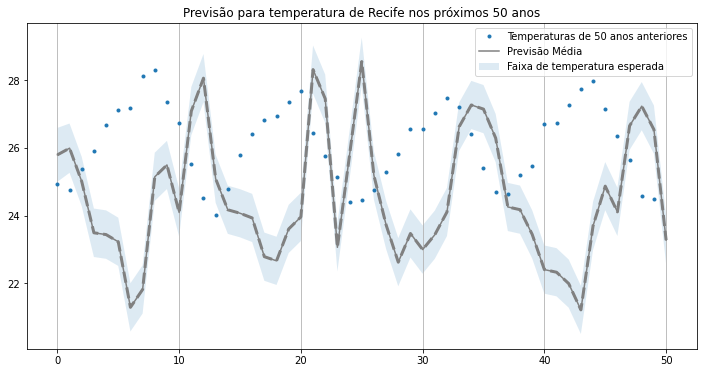

In [231]:
n_anos_pred = 53

recife_pred_SARIMAX = pred_SARIMAX.get_prediction(end = n_anos_pred)
eixoX = np.arange(len(recife_pred_SARIMAX.predicted_mean))
predict_ints = recife_pred_SARIMAX.conf_int(alpha=0.5)

fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(recife['AverageTemperature'].values[-(n_anos_pred-2):], '.', label='Temperaturas de 50 anos anteriores')

# Por alguma razão a temperatura dos 2 primeiros valores excede 600°C, então é feito descarte
p, = ax.plot(np.arange(0,n_anos_pred-2,1), (predict_ints['lower AverageTemperature'][3:]+predict_ints['upper AverageTemperature'][3:])/2, 'gray', label='Previsão Média')
ax.plot(np.arange(0,n_anos_pred-2,1), (predict_ints['lower AverageTemperature'][3:]+predict_ints['upper AverageTemperature'][3:])/2, 'gray', linestyle='--', linewidth=3)
predict_ints.reset_index(drop=True, inplace=True)
ax.fill_between(np.arange(0,n_anos_pred-2,1), predict_ints['lower AverageTemperature'][3:], predict_ints['upper AverageTemperature'][3:], alpha=0.15, label='Faixa de temperatura esperada')
ax.legend()
ax.set(title='Previsão para temperatura de Recife nos próximos 50 anos');

##### Previsão do SARIMA
A previsão dada pelo SARIMA nos mostra uma variação estranha, sendo provável que exista uma melhor configuração dos parâmetros. 

### Previsões
Nessa seção vamos passar por uma lista de algoritmos diferentes de predição. Mostrando os resultados obtidos com o mesmo espaço amostral das temperaturas de Recife para cada uma.


#### Regressão Linear
A primeira usada será a tradicional Regressão Linear, o qual obtivemos um Score de 57.27%.

Score:  0.6025403495339645


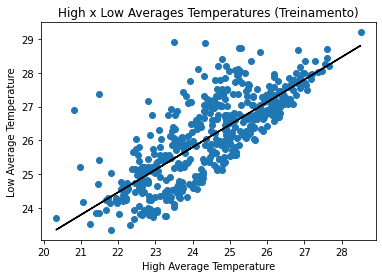

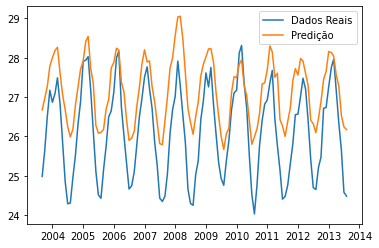

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

recife = df_cidade[df_cidade['City'] == 'Recife']
recife = recife.dropna(axis=0)

# Criamos uma abstração, duas colunas baseadas na incerteza de temperatura da média
# variando para cima ou para baixo
recife['LowAverageTemperature'] = recife['AverageTemperature'].values - recife['AverageTemperatureUncertainty']
recife['HighAverageTemperature'] = recife['AverageTemperature'].values + recife['AverageTemperatureUncertainty']
y = recife['HighAverageTemperature'] # Max
x = recife['LowAverageTemperature']  # Min

x = x.values.reshape(-1,1)
y = y.values.reshape(-1,1)

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25)

# Usando Regressão Linear
reg_linear = LinearRegression()
model=reg_linear.fit(x_train,y_train)

print('Score: ',reg_linear.score(x_test,y_test))

plt.scatter(x_test, y_test)
plt.plot(x_test, reg_linear.predict(x_test), color='black')
plt.title('High x Low Averages Temperatures (Treinamento)')
plt.xlabel('High Average Temperature')
plt.ylabel('Low Average Temperature')
plt.show()

# Dados dos últimos 10 anos do dataset
plt.plot(recife.dt.tail(120), recife.AverageTemperature.tail(120), label='Dados Reais')

# Dados selecionados de 10 anos há 20 anos atrás
plt.plot(recife.dt.tail(120), reg_linear.predict(recife.AverageTemperature.values[-240:-120].reshape(-1,1)), label='Predição')
plt.legend()
plt.show()

#### Random Forest Regressor

No Random Forest podemos definir o número de estimadores e a profundidade máxima buscada. Definimos, por arbitrariedade, o número de estimadores como 25 e profundidade máxima até 8. No qual o Score foi 58,22%.



In [84]:
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import optuna
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

recife = df_cidade[df_cidade['City'] == 'Recife']

recife = df_cidade[df_cidade['City'] == 'Recife']
recife = recife.dropna(axis=0)

recife['LowAverageTemperature'] = recife['AverageTemperature'].values - recife['AverageTemperatureUncertainty']
recife['HighAverageTemperature'] = recife['AverageTemperature'].values + recife['AverageTemperatureUncertainty']
y = recife['HighAverageTemperature'] # Max
x = recife['LowAverageTemperature']  # Min

x = x.values.reshape(-1,1)
y = y.values
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.1)
regr = RandomForestRegressor(max_depth=8, n_estimators=25, random_state=0)
regr.fit(x_train,y_train)

print('Score entre testes: ',regr.score(X=x_test, y=y_test))

Score entre testes:  0.5439435638824559


#### Holt-Winters
Para o Holt-Winters podemos definir 3 parâmetros: Sazonalidade, Tendência e seasonal_periods, que tomamos valor para 12. Ambos podem assumir os valores de "mul" ou "add", que são referentes a variação dos dados na série:
* add: variações são praticamente constantes na série
* mul: variações mudam proporcionalmente para cada nível da série
Adotamos o seasonal_periods para 12

Text(0.5, 0, 'Previsão para os próximos 120 meses')

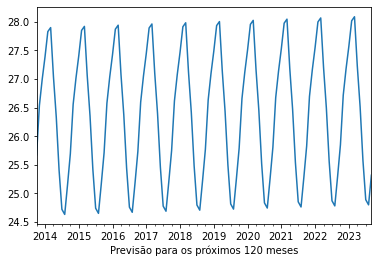

In [85]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

recife = df_cidade[df_cidade['City'] == 'Recife']
recife.set_index('dt', inplace=True)
recife.index = recife.index.to_period('M')

recife['AverageTemperature'] = recife['AverageTemperature'].fillna(value=recife.AverageTemperature.mean())

range_anos_previsao = 120
resultado3 = ExponentialSmoothing(recife['AverageTemperature'], seasonal_periods=12, trend='add', seasonal='mul')
previsao3  = resultado3.fit()
previsao3.forecast(range_anos_previsao).plot()

plt.xlabel('Previsão para os próximos {} meses'.format(range_anos_previsao))

#### K-Neighbors

Para usar este modelo, criamos duas tabelas (somando e subtraindo na tabela de temperatura média), sendo estas baseadas na tabela de incerteza da temperatura média que temos. Aqui obtivemos um Score de 73.69%;

Score entre testes:  0.7589257485340579


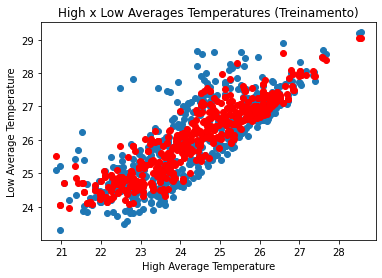

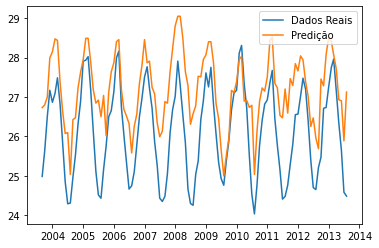

In [86]:
from sklearn.neighbors import KNeighborsRegressor

recife = df_cidade[df_cidade['City'] == 'Recife']
recife = recife.dropna(axis=0)

recife['LowAverageTemperature'] = recife['AverageTemperature'].values - recife['AverageTemperatureUncertainty']
recife['HighAverageTemperature'] = recife['AverageTemperature'].values + recife['AverageTemperatureUncertainty']
y = recife['HighAverageTemperature'] # Max
x = recife['LowAverageTemperature']  # Min

x = x.values.reshape(-1,1)
y = y.values.reshape(-1,1)

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25)

# Usando KNeighbors como Regressor
vizinhos_3 = KNeighborsRegressor(n_neighbors=3)
modelo = vizinhos_3.fit(x, y)

print('Score entre testes: ',vizinhos_3.score(x_test,y_test))

plt.scatter(x_test, y_test)
plt.scatter(x_test, vizinhos_3.predict(x_test), color='red')
plt.title('High x Low Averages Temperatures (Treinamento)')
plt.xlabel('High Average Temperature')
plt.ylabel('Low Average Temperature')
plt.show()

# Dados dos últimos 10 anos do dataset
plt.plot(recife.dt.tail(120), recife.AverageTemperature.tail(120), label='Dados Reais')

# Dados selecionados de 10 anos a partir de 20 anos atrás
plt.plot(recife.dt.tail(120), vizinhos_3.predict(recife.AverageTemperature.values[-240:-120].reshape(-1,1)), label='Predição')
plt.legend()
plt.show()

#### Análise parcial
Até então temos que a Random Forest e o K-Neighbors-Regressor são os melhores nossos melhores algoritmos testados. Vamos agora fazer testes modificando hiperparâmetros para ver se podemos melhorar nosso modelo.

### Usando MLFlow
Aqui podemos usar o KNeighbors, Gradient Boosting Regressor (foi escolhido pela semelhança de parâmetros com o Random Forest, pois o Sklearn não tem KNeighbors para usar na próxima etapa em conjunto com Optuna) e o Random Forest. 

In [259]:
import mlflow
import mlflow.sklearn
from sklearn import metrics
from datetime import datetime

from sklearn.metrics import r2_score

recife = df_cidade[df_cidade['City'] == 'Recife']
recife = recife.dropna(axis=0)

recife['LowAverageTemperature'] = recife['AverageTemperature'].values - recife['AverageTemperatureUncertainty'].values
recife['LowAverageTemperature'] = [int(k) for k in recife['LowAverageTemperature']]
recife['HighAverageTemperature'] = recife['AverageTemperature'].values + recife['AverageTemperatureUncertainty'].values
recife['HighAverageTemperature'] = [int(k) for k in recife['HighAverageTemperature']]
y = recife['HighAverageTemperature'] # Max
x = recife['LowAverageTemperature']  # Min
y = y.values
x = x.values.reshape(-1,1)
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25)

with mlflow.start_run():
    vizinhos_3 = KNeighborsRegressor(n_neighbors=3)
    modelo = vizinhos_3.fit(x_train, y_train)
    x_pred = modelo.predict(x_test)
    score = r2_score(x_pred, y_test)
    mlflow.log_param('random-state', 0)
    mlflow.log_metric('r2', score)
    mlflow.sklearn.log_model(vizinhos_3, 'modelo')
    caminho_modelo = 'modelo'
    mlflow.sklearn.save_model(vizinhos_3, path='./modelo/mlflow/model-kneighbors-%i'%(int(datetime.now().timestamp())))

In [256]:
recife = df_cidade[df_cidade['City'] == 'Recife']
recife = recife.dropna(axis=0)

recife['LowAverageTemperature'] = recife['AverageTemperature'].values - recife['AverageTemperatureUncertainty'].values
recife['LowAverageTemperature'] = [int(k) for k in recife['LowAverageTemperature']]
recife['HighAverageTemperature'] = recife['AverageTemperature'].values + recife['AverageTemperatureUncertainty'].values
recife['HighAverageTemperature'] = [int(k) for k in recife['HighAverageTemperature']]
y = recife['HighAverageTemperature'] # Max
x = recife['LowAverageTemperature']  # Min
y = y.values
x = x.values.reshape(-1,1)
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25)

with mlflow.start_run():
    regressor = GradientBoostingRegressor(max_depth=2, n_estimators=63, random_state=0)
    modelo = regressor.fit(x_train, y_train)
    x_pred = modelo.predict(x_test)
    score = r2_score(x_pred, y_test)
    mlflow.log_param('random-state', 0)
    mlflow.log_metric('r2', score)
    mlflow.sklearn.log_model(regressor, 'mlflow')
    mlflow.sklearn.save_model(regressor, path='./modelo/mlflow/model-gradient-boosting-%i'%(int(datetime.now().timestamp())))
    mlflow.end_run()

In [257]:
recife = df_cidade[df_cidade['City'] == 'Recife']
recife = recife.dropna(axis=0)

recife['LowAverageTemperature'] = recife['AverageTemperature'].values - recife['AverageTemperatureUncertainty'].values
recife['LowAverageTemperature'] = [int(k) for k in recife['LowAverageTemperature']]
recife['HighAverageTemperature'] = recife['AverageTemperature'].values + recife['AverageTemperatureUncertainty'].values
recife['HighAverageTemperature'] = [int(k) for k in recife['HighAverageTemperature']]
y = recife['HighAverageTemperature'] # Max
x = recife['LowAverageTemperature']  # Min
y = y.values
x = x.values.reshape(-1,1)
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25)

with mlflow.start_run():
    regressor = RandomForestRegressor(max_depth=3, n_estimators=47, random_state=0)
    modelo = regressor.fit(x_train, y_train)
    x_pred = modelo.predict(x_test)
    score = r2_score(x_pred, y_test)
    mlflow.log_param('random-state', 0)
    mlflow.log_metric('r2', score)
    mlflow.sklearn.log_model(regressor, 'mlflow')
    mlflow.sklearn.save_model(regressor, path='./modelo/mlflow/model-random-forest-%i'%(int(datetime.now().timestamp())))
    mlflow.end_run()

### Alteração de hiperparâmetros


#### Random Forest Regressor
Iremos testar aumento usando a Random Forest com número de estimadores variando de 25 a 50 e a profundidade máxima variando de 2 a 64.

In [87]:
import optuna

recife['LowAverageTemperature'] = recife['AverageTemperature'].values - recife['AverageTemperatureUncertainty']
recife['HighAverageTemperature'] = recife['AverageTemperature'].values + recife['AverageTemperatureUncertainty']
x = recife['LowAverageTemperature']  # Min
y = recife['HighAverageTemperature'] # Max
x = x.values.reshape(-1,1)
y = y.values
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25)

def meta(trial):
    sugestao = trial.suggest_float(name='AverageTemperature', low=x.min(), high=y.max())

    n_estimadores = trial.suggest_int("rf_n_estimators", 25, 50)
    max_profundidade = trial.suggest_int("rf_max_depth", 2, 64, log=True)

    regressor = sklearn.ensemble.RandomForestRegressor(max_depth=max_profundidade, n_estimators=n_estimadores, random_state=0)
    score = sklearn.model_selection.cross_val_score(regressor, x_train, y_train, n_jobs=-1)
    
    for passo in range(100):
        regressor.fit(x_train, y_train)
        valor_intermediario = regressor.score(x_test, y_test)
        trial.report(valor_intermediario, passo)

        if trial.should_prune():
            # Deveria ser feita a poda
            raise optuna.TrialPruned()
        return valor_intermediario
    
    acuracia = score.mean()
    return print('Acurácia: ',acuracia)

estudo = optuna.create_study(direction='maximize')
estudo.optimize(meta, n_trials=100)
podas_testadas = [et for et in estudo.trials if et.state == optuna.trial.TrialState.PRUNED]
completos_testes = [et for et in estudo.trials if et.state == optuna.trial.TrialState.COMPLETE]

print('Testes encerrados, podados e completos:', len(estudo.trials), len(podas_testadas), len(completos_testes))


[I 2020-11-17 23:09:00,393] A new study created in memory with name: no-name-91e4c6de-b270-4bcb-865b-908dcad7813a
[I 2020-11-17 23:09:02,042] Trial 0 finished with value: 0.5527336700483564 and parameters: {'AverageTemperature': 22.204344754573036, 'rf_n_estimators': 42, 'rf_max_depth': 9}. Best is trial 0 with value: 0.5527336700483564.
[I 2020-11-17 23:09:02,468] Trial 1 finished with value: 0.5819487517897104 and parameters: {'AverageTemperature': 21.69296222014073, 'rf_n_estimators': 49, 'rf_max_depth': 4}. Best is trial 1 with value: 0.5819487517897104.
[I 2020-11-17 23:09:02,847] Trial 2 finished with value: 0.5570294833888328 and parameters: {'AverageTemperature': 23.34065035372059, 'rf_n_estimators': 48, 'rf_max_depth': 2}. Best is trial 1 with value: 0.5819487517897104.
[I 2020-11-17 23:09:03,500] Trial 3 finished with value: 0.45784673446320806 and parameters: {'AverageTemperature': 26.350048950921785, 'rf_n_estimators': 49, 'rf_max_depth': 16}. Best is trial 1 with value: 0.

Testes encerrados, podados e completos: 100 62 38


#### Gradient Boosting Regressor
Dado que não há KNeighbors para testarmos no Sklearn Ensamble, iremos testar outra abordagem similar no quesito de parâmetros ao Random Forest usando o Gradient Boosting Regressor com número de estimadores variando de 25 a 100 e a profundidade máxima variando de 2 a 32, só que com Warm-State definido para True, podendo método otimizar-se bastante por si só.

In [254]:
from sklearn.ensemble import GradientBoostingRegressor

recife = df_cidade[df_cidade['City'] == 'Recife']
recife = recife.dropna(axis=0)

recife['LowAverageTemperature'] = recife['AverageTemperature'].values - recife['AverageTemperatureUncertainty']
recife['HighAverageTemperature'] = recife['AverageTemperature'].values + recife['AverageTemperatureUncertainty']
x = recife['LowAverageTemperature']  # Min
y = recife['HighAverageTemperature'] # Max
x = x.values.reshape(-1,1)
y = y.values
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25)

def meta(trial):
    sugestao = trial.suggest_float(name='AverageTemperature', low=x.min(), high=y.max())

    n_estimadores = trial.suggest_int("rf_n_estimators", 25, 100)
    max_profundidade = trial.suggest_int("rf_max_depth", 2, 32, log=True)

    regressor = sklearn.ensemble.GradientBoostingRegressor(max_depth=max_profundidade, n_estimators=n_estimadores, random_state=0, warm_start=True)
    score = sklearn.model_selection.cross_val_score(regressor, x_train, y_train, n_jobs=-1)
    
    regressor.fit(x_train, y_train)
    valor_intermediario = regressor.score(x_test, y_test)
    trial.report(valor_intermediario, trial.number)
    
    acuracia = score.mean()
    print('Acurácia: ',acuracia)
    return acuracia

estudo = optuna.create_study(direction='maximize')
estudo.optimize(meta, n_trials=100)

[I 2020-11-18 01:54:06,968] A new study created in memory with name: no-name-d15f10d2-2719-4795-8f11-8ad15eb0d5e0
[I 2020-11-18 01:54:07,337] Trial 0 finished with value: 0.30326796063704764 and parameters: {'AverageTemperature': 27.981912117790696, 'rf_n_estimators': 32, 'rf_max_depth': 17}. Best is trial 0 with value: 0.30326796063704764.
[I 2020-11-18 01:54:07,484] Trial 1 finished with value: 0.5879183281221307 and parameters: {'AverageTemperature': 23.617516591419157, 'rf_n_estimators': 43, 'rf_max_depth': 2}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.30326796063704764
Acurácia:  0.5879183281221307


[I 2020-11-18 01:54:08,550] Trial 2 finished with value: 0.2558462908393619 and parameters: {'AverageTemperature': 26.115654794905794, 'rf_n_estimators': 91, 'rf_max_depth': 27}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.2558462908393619


[I 2020-11-18 01:54:08,859] Trial 3 finished with value: 0.5860166445261173 and parameters: {'AverageTemperature': 20.466437240971043, 'rf_n_estimators': 94, 'rf_max_depth': 2}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5860166445261173


[I 2020-11-18 01:54:09,141] Trial 4 finished with value: 0.5837303953674351 and parameters: {'AverageTemperature': 29.49570450564643, 'rf_n_estimators': 71, 'rf_max_depth': 3}. Best is trial 1 with value: 0.5879183281221307.
[I 2020-11-18 01:54:09,298] Trial 5 finished with value: 0.5858848571201865 and parameters: {'AverageTemperature': 25.368463552252628, 'rf_n_estimators': 36, 'rf_max_depth': 3}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5837303953674351
Acurácia:  0.5858848571201865


[I 2020-11-18 01:54:09,474] Trial 6 finished with value: 0.5859528758689526 and parameters: {'AverageTemperature': 26.90393357174522, 'rf_n_estimators': 41, 'rf_max_depth': 3}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5859528758689526


[I 2020-11-18 01:54:09,828] Trial 7 finished with value: 0.5094408122581353 and parameters: {'AverageTemperature': 23.90270861536128, 'rf_n_estimators': 47, 'rf_max_depth': 8}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5094408122581353


[I 2020-11-18 01:54:10,072] Trial 8 finished with value: 0.5876749216560527 and parameters: {'AverageTemperature': 22.065283339207646, 'rf_n_estimators': 73, 'rf_max_depth': 2}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5876749216560527


[I 2020-11-18 01:54:10,397] Trial 9 finished with value: 0.46572806507304276 and parameters: {'AverageTemperature': 25.644592543956072, 'rf_n_estimators': 38, 'rf_max_depth': 10}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.46572806507304276


[I 2020-11-18 01:54:10,738] Trial 10 finished with value: 0.5535724850398133 and parameters: {'AverageTemperature': 23.228781629068994, 'rf_n_estimators': 54, 'rf_max_depth': 6}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5535724850398133


[I 2020-11-18 01:54:10,979] Trial 11 finished with value: 0.5873437004260438 and parameters: {'AverageTemperature': 21.33728931310185, 'rf_n_estimators': 71, 'rf_max_depth': 2}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5873437004260438


[I 2020-11-18 01:54:11,243] Trial 12 finished with value: 0.5871486690400605 and parameters: {'AverageTemperature': 22.340119309029745, 'rf_n_estimators': 79, 'rf_max_depth': 2}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5871486690400605


[I 2020-11-18 01:54:11,531] Trial 13 finished with value: 0.5755118476878177 and parameters: {'AverageTemperature': 23.220873021739173, 'rf_n_estimators': 58, 'rf_max_depth': 4}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5755118476878177


[I 2020-11-18 01:54:11,806] Trial 14 finished with value: 0.5869728532589392 and parameters: {'AverageTemperature': 21.500313781959083, 'rf_n_estimators': 83, 'rf_max_depth': 2}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5869728532589392


[I 2020-11-18 01:54:12,034] Trial 15 finished with value: 0.5875328451880024 and parameters: {'AverageTemperature': 24.266101006663344, 'rf_n_estimators': 66, 'rf_max_depth': 2}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5875328451880024


[I 2020-11-18 01:54:12,306] Trial 16 finished with value: 0.5672412504045864 and parameters: {'AverageTemperature': 20.569510084759713, 'rf_n_estimators': 50, 'rf_max_depth': 5}. Best is trial 1 with value: 0.5879183281221307.
[I 2020-11-18 01:54:12,411] Trial 17 finished with value: 0.583654788208297 and parameters: {'AverageTemperature': 22.309427239572468, 'rf_n_estimators': 25, 'rf_max_depth': 2}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5672412504045864
Acurácia:  0.583654788208297


[I 2020-11-18 01:54:12,709] Trial 18 finished with value: 0.574697989258316 and parameters: {'AverageTemperature': 24.36142303629321, 'rf_n_estimators': 62, 'rf_max_depth': 4}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.574697989258316


[I 2020-11-18 01:54:12,992] Trial 19 finished with value: 0.5871108597785237 and parameters: {'AverageTemperature': 22.47151638475142, 'rf_n_estimators': 81, 'rf_max_depth': 2}. Best is trial 1 with value: 0.5879183281221307.
[I 2020-11-18 01:54:13,100] Trial 20 finished with value: 0.5840839433634155 and parameters: {'AverageTemperature': 21.05260395093553, 'rf_n_estimators': 26, 'rf_max_depth': 2}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5871108597785237
Acurácia:  0.5840839433634155


[I 2020-11-18 01:54:13,337] Trial 21 finished with value: 0.5871686366312764 and parameters: {'AverageTemperature': 24.212544472885515, 'rf_n_estimators': 70, 'rf_max_depth': 2}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5871686366312764


[I 2020-11-18 01:54:13,559] Trial 22 finished with value: 0.5875328451880024 and parameters: {'AverageTemperature': 23.29370648271968, 'rf_n_estimators': 66, 'rf_max_depth': 2}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5875328451880024


[I 2020-11-18 01:54:13,881] Trial 23 finished with value: 0.5837570465594476 and parameters: {'AverageTemperature': 23.214707244506226, 'rf_n_estimators': 76, 'rf_max_depth': 3}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5837570465594476


[I 2020-11-18 01:54:14,099] Trial 24 finished with value: 0.5877772970549152 and parameters: {'AverageTemperature': 24.60464475047797, 'rf_n_estimators': 61, 'rf_max_depth': 2}. Best is trial 1 with value: 0.5879183281221307.
[I 2020-11-18 01:54:14,256] Trial 25 finished with value: 0.5876377228074668 and parameters: {'AverageTemperature': 25.014203058228595, 'rf_n_estimators': 45, 'rf_max_depth': 2}. Best is trial 1 with value: 0.5879183281221307.


Acurácia:  0.5877772970549152
Acurácia:  0.5876377228074668


[I 2020-11-18 01:54:14,458] Trial 26 finished with value: 0.5879147285627477 and parameters: {'AverageTemperature': 27.243112455894074, 'rf_n_estimators': 58, 'rf_max_depth': 2}. Best is trial 1 with value: 0.5879183281221307.
[I 2020-11-18 01:54:14,646] Trial 27 finished with value: 0.5883331385667334 and parameters: {'AverageTemperature': 27.624857706008655, 'rf_n_estimators': 54, 'rf_max_depth': 2}. Best is trial 27 with value: 0.5883331385667334.


Acurácia:  0.5879147285627477
Acurácia:  0.5883331385667334


[I 2020-11-18 01:54:14,880] Trial 28 finished with value: 0.5846986741068246 and parameters: {'AverageTemperature': 28.445050524608725, 'rf_n_estimators': 55, 'rf_max_depth': 3}. Best is trial 27 with value: 0.5883331385667334.
[I 2020-11-18 01:54:15,065] Trial 29 finished with value: 0.5884294959093687 and parameters: {'AverageTemperature': 27.67862505295659, 'rf_n_estimators': 51, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.


Acurácia:  0.5846986741068246
Acurácia:  0.5884294959093687


[I 2020-11-18 01:54:15,428] Trial 30 finished with value: 0.33212925076745375 and parameters: {'AverageTemperature': 29.828509388428387, 'rf_n_estimators': 33, 'rf_max_depth': 15}. Best is trial 29 with value: 0.5884294959093687.


Acurácia:  0.33212925076745375


[I 2020-11-18 01:54:15,646] Trial 31 finished with value: 0.5856457752646038 and parameters: {'AverageTemperature': 27.718274799197264, 'rf_n_estimators': 52, 'rf_max_depth': 3}. Best is trial 29 with value: 0.5884294959093687.
[I 2020-11-18 01:54:15,812] Trial 32 finished with value: 0.5878287342012256 and parameters: {'AverageTemperature': 26.809139523075316, 'rf_n_estimators': 44, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.


Acurácia:  0.5856457752646038
Acurácia:  0.5878287342012256


[I 2020-11-18 01:54:15,989] Trial 33 finished with value: 0.5874211466181076 and parameters: {'AverageTemperature': 28.242037601593882, 'rf_n_estimators': 49, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.


Acurácia:  0.5874211466181076


[I 2020-11-18 01:54:16,193] Trial 34 finished with value: 0.5879147285627477 and parameters: {'AverageTemperature': 28.97791366297884, 'rf_n_estimators': 58, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.
[I 2020-11-18 01:54:16,367] Trial 35 finished with value: 0.5857300003806589 and parameters: {'AverageTemperature': 29.067317629918, 'rf_n_estimators': 40, 'rf_max_depth': 3}. Best is trial 29 with value: 0.5884294959093687.


Acurácia:  0.5879147285627477
Acurácia:  0.5857300003806589


[I 2020-11-18 01:54:16,486] Trial 36 finished with value: 0.5861466013696667 and parameters: {'AverageTemperature': 27.216326438600433, 'rf_n_estimators': 30, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.
[I 2020-11-18 01:54:16,675] Trial 37 finished with value: 0.5877428683609175 and parameters: {'AverageTemperature': 28.925961965479697, 'rf_n_estimators': 56, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.


Acurácia:  0.5861466013696667
Acurácia:  0.5877428683609175


[I 2020-11-18 01:54:16,837] Trial 38 finished with value: 0.5879183281221307 and parameters: {'AverageTemperature': 25.83088931734111, 'rf_n_estimators': 43, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.
[I 2020-11-18 01:54:16,990] Trial 39 finished with value: 0.5879183281221307 and parameters: {'AverageTemperature': 26.43626535193653, 'rf_n_estimators': 43, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.


Acurácia:  0.5879183281221307
Acurácia:  0.5879183281221307


[I 2020-11-18 01:54:17,136] Trial 40 finished with value: 0.5874266319241036 and parameters: {'AverageTemperature': 26.322190230168086, 'rf_n_estimators': 34, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.
[I 2020-11-18 01:54:17,295] Trial 41 finished with value: 0.5880816620393842 and parameters: {'AverageTemperature': 26.013079538628077, 'rf_n_estimators': 42, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.


Acurácia:  0.5874266319241036
Acurácia:  0.5880816620393842


[I 2020-11-18 01:54:17,435] Trial 42 finished with value: 0.5878662276740901 and parameters: {'AverageTemperature': 26.674494756770194, 'rf_n_estimators': 37, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.
[I 2020-11-18 01:54:17,599] Trial 43 finished with value: 0.5876827216229575 and parameters: {'AverageTemperature': 26.098500389484776, 'rf_n_estimators': 46, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.


Acurácia:  0.5878662276740901
Acurácia:  0.5876827216229575


[I 2020-11-18 01:54:17,755] Trial 44 finished with value: 0.5879306944014944 and parameters: {'AverageTemperature': 25.160938518353113, 'rf_n_estimators': 41, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.
[I 2020-11-18 01:54:17,878] Trial 45 finished with value: 0.5856648705470386 and parameters: {'AverageTemperature': 25.209913306140876, 'rf_n_estimators': 29, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.


Acurácia:  0.5879306944014944
Acurácia:  0.5856648705470386


[I 2020-11-18 01:54:18,058] Trial 46 finished with value: 0.5875354499559251 and parameters: {'AverageTemperature': 27.54978941040702, 'rf_n_estimators': 50, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.
[I 2020-11-18 01:54:18,200] Trial 47 finished with value: 0.5876395830465266 and parameters: {'AverageTemperature': 24.833219462391515, 'rf_n_estimators': 39, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.


Acurácia:  0.5875354499559251
Acurácia:  0.5876395830465266


[I 2020-11-18 01:54:18,357] Trial 48 finished with value: 0.5880816620393842 and parameters: {'AverageTemperature': 25.767830739728037, 'rf_n_estimators': 42, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.
[I 2020-11-18 01:54:18,526] Trial 49 finished with value: 0.5875564638287263 and parameters: {'AverageTemperature': 25.715995027146693, 'rf_n_estimators': 48, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.


Acurácia:  0.5880816620393842
Acurácia:  0.5875564638287263


[I 2020-11-18 01:54:18,718] Trial 50 finished with value: 0.5883233378739662 and parameters: {'AverageTemperature': 25.499191636474617, 'rf_n_estimators': 53, 'rf_max_depth': 2}. Best is trial 29 with value: 0.5884294959093687.
[I 2020-11-18 01:54:18,904] Trial 51 finished with value: 0.5885320218582397 and parameters: {'AverageTemperature': 25.21807981496261, 'rf_n_estimators': 52, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5883233378739662
Acurácia:  0.5885320218582397


[I 2020-11-18 01:54:19,136] Trial 52 finished with value: 0.5855857582977785 and parameters: {'AverageTemperature': 25.46038807226596, 'rf_n_estimators': 53, 'rf_max_depth': 3}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:19,319] Trial 53 finished with value: 0.5885320218582397 and parameters: {'AverageTemperature': 26.025592965679948, 'rf_n_estimators': 52, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5855857582977785
Acurácia:  0.5885320218582397


[I 2020-11-18 01:54:19,501] Trial 54 finished with value: 0.5885320218582397 and parameters: {'AverageTemperature': 26.982667105002843, 'rf_n_estimators': 52, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5885320218582397


[I 2020-11-18 01:54:19,720] Trial 55 finished with value: 0.5876411275595449 and parameters: {'AverageTemperature': 27.142635995098317, 'rf_n_estimators': 65, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5876411275595449


[I 2020-11-18 01:54:19,943] Trial 56 finished with value: 0.5878439789092025 and parameters: {'AverageTemperature': 27.81509060228629, 'rf_n_estimators': 60, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:20,127] Trial 57 finished with value: 0.5885320218582397 and parameters: {'AverageTemperature': 26.444818913840468, 'rf_n_estimators': 52, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5878439789092025
Acurácia:  0.5885320218582397


[I 2020-11-18 01:54:20,305] Trial 58 finished with value: 0.5884294959093687 and parameters: {'AverageTemperature': 28.271470173532236, 'rf_n_estimators': 51, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:20,504] Trial 59 finished with value: 0.585217480923987 and parameters: {'AverageTemperature': 28.13023476266668, 'rf_n_estimators': 47, 'rf_max_depth': 3}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5884294959093687
Acurácia:  0.585217480923987


[I 2020-11-18 01:54:20,713] Trial 60 finished with value: 0.5876672961297249 and parameters: {'AverageTemperature': 28.447330938128346, 'rf_n_estimators': 64, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5876672961297249


[I 2020-11-18 01:54:20,917] Trial 61 finished with value: 0.5877428683609175 and parameters: {'AverageTemperature': 26.56184021562921, 'rf_n_estimators': 56, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:21,095] Trial 62 finished with value: 0.5884294959093687 and parameters: {'AverageTemperature': 27.49149495055298, 'rf_n_estimators': 51, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5877428683609175
Acurácia:  0.5884294959093687


[I 2020-11-18 01:54:21,282] Trial 63 finished with value: 0.5884294959093687 and parameters: {'AverageTemperature': 27.109517946861434, 'rf_n_estimators': 51, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5884294959093687


[I 2020-11-18 01:54:21,616] Trial 64 finished with value: 0.5858514048390759 and parameters: {'AverageTemperature': 26.98480496733877, 'rf_n_estimators': 100, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5858514048390759


[I 2020-11-18 01:54:21,819] Trial 65 finished with value: 0.5878439789092025 and parameters: {'AverageTemperature': 26.361521064784448, 'rf_n_estimators': 60, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:22,006] Trial 66 finished with value: 0.5884294959093687 and parameters: {'AverageTemperature': 27.491649975304814, 'rf_n_estimators': 51, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:22,173] Trial 67 finished with value: 0.5875564638287263 and parameters: {'AverageTemperature': 28.685378809956205, 'rf_n_estimators': 48, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5878439789092025
Acurácia:  0.5884294959093687
Acurácia:  0.5875564638287263


[I 2020-11-18 01:54:22,379] Trial 68 finished with value: 0.5878415307516324 and parameters: {'AverageTemperature': 26.99581498539515, 'rf_n_estimators': 57, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:22,539] Trial 69 finished with value: 0.5876827216229575 and parameters: {'AverageTemperature': 27.330006193902424, 'rf_n_estimators': 46, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5878415307516324
Acurácia:  0.5876827216229575


[I 2020-11-18 01:54:22,732] Trial 70 finished with value: 0.5883233378739662 and parameters: {'AverageTemperature': 27.993717469286263, 'rf_n_estimators': 53, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:22,908] Trial 71 finished with value: 0.5875354499559251 and parameters: {'AverageTemperature': 27.431003631975752, 'rf_n_estimators': 50, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5883233378739662
Acurácia:  0.5875354499559251


[I 2020-11-18 01:54:23,091] Trial 72 finished with value: 0.5884294959093687 and parameters: {'AverageTemperature': 26.755510534744392, 'rf_n_estimators': 51, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:23,291] Trial 73 finished with value: 0.5881509014927196 and parameters: {'AverageTemperature': 26.82498298733219, 'rf_n_estimators': 55, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5884294959093687
Acurácia:  0.5881509014927196


[I 2020-11-18 01:54:23,516] Trial 74 finished with value: 0.5879147285627477 and parameters: {'AverageTemperature': 27.707846837686827, 'rf_n_estimators': 58, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5879147285627477


[I 2020-11-18 01:54:23,730] Trial 75 finished with value: 0.587449947443218 and parameters: {'AverageTemperature': 29.364858371360068, 'rf_n_estimators': 62, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:23,905] Trial 76 finished with value: 0.5875564638287263 and parameters: {'AverageTemperature': 26.1020230651531, 'rf_n_estimators': 48, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.587449947443218
Acurácia:  0.5875564638287263


[I 2020-11-18 01:54:24,137] Trial 77 finished with value: 0.587161939335809 and parameters: {'AverageTemperature': 26.71568301048214, 'rf_n_estimators': 68, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:24,312] Trial 78 finished with value: 0.5885320218582397 and parameters: {'AverageTemperature': 28.351936408321173, 'rf_n_estimators': 52, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.587161939335809
Acurácia:  0.5885320218582397


[I 2020-11-18 01:54:24,514] Trial 79 finished with value: 0.5883331385667334 and parameters: {'AverageTemperature': 28.2076107757017, 'rf_n_estimators': 54, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:24,675] Trial 80 finished with value: 0.5876827216229575 and parameters: {'AverageTemperature': 25.97485521770759, 'rf_n_estimators': 46, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5883331385667334
Acurácia:  0.5876827216229575


[I 2020-11-18 01:54:24,862] Trial 81 finished with value: 0.5885320218582397 and parameters: {'AverageTemperature': 28.48207784346611, 'rf_n_estimators': 52, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5885320218582397


[I 2020-11-18 01:54:25,075] Trial 82 finished with value: 0.5879937383580057 and parameters: {'AverageTemperature': 28.591418642547595, 'rf_n_estimators': 59, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:25,255] Trial 83 finished with value: 0.5885320218582397 and parameters: {'AverageTemperature': 29.498853337731457, 'rf_n_estimators': 52, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5879937383580057
Acurácia:  0.5885320218582397


[I 2020-11-18 01:54:25,448] Trial 84 finished with value: 0.5877428683609175 and parameters: {'AverageTemperature': 29.11062735438388, 'rf_n_estimators': 56, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:25,603] Trial 85 finished with value: 0.5878287342012256 and parameters: {'AverageTemperature': 29.254558111317184, 'rf_n_estimators': 44, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5877428683609175
Acurácia:  0.5878287342012256


[I 2020-11-18 01:54:25,776] Trial 86 finished with value: 0.5874211466181076 and parameters: {'AverageTemperature': 29.479275405536697, 'rf_n_estimators': 49, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:25,966] Trial 87 finished with value: 0.5885320218582397 and parameters: {'AverageTemperature': 28.674025834164237, 'rf_n_estimators': 52, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5874211466181076
Acurácia:  0.5885320218582397


[I 2020-11-18 01:54:26,156] Trial 88 finished with value: 0.5881509014927196 and parameters: {'AverageTemperature': 28.745803429892476, 'rf_n_estimators': 55, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:26,343] Trial 89 finished with value: 0.5883233378739662 and parameters: {'AverageTemperature': 27.90508625849435, 'rf_n_estimators': 53, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5881509014927196
Acurácia:  0.5883233378739662


[I 2020-11-18 01:54:26,511] Trial 90 finished with value: 0.5876377228074668 and parameters: {'AverageTemperature': 29.557085477194246, 'rf_n_estimators': 45, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:26,691] Trial 91 finished with value: 0.5885320218582397 and parameters: {'AverageTemperature': 28.32724463751774, 'rf_n_estimators': 52, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5876377228074668
Acurácia:  0.5885320218582397


[I 2020-11-18 01:54:26,865] Trial 92 finished with value: 0.5874211466181076 and parameters: {'AverageTemperature': 28.470121865637502, 'rf_n_estimators': 49, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5874211466181076


[I 2020-11-18 01:54:27,069] Trial 93 finished with value: 0.5878415307516324 and parameters: {'AverageTemperature': 29.763103106068826, 'rf_n_estimators': 57, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:27,255] Trial 94 finished with value: 0.5885320218582397 and parameters: {'AverageTemperature': 24.678183758423266, 'rf_n_estimators': 52, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5878415307516324
Acurácia:  0.5885320218582397


[I 2020-11-18 01:54:27,453] Trial 95 finished with value: 0.5883331385667334 and parameters: {'AverageTemperature': 24.47923956413522, 'rf_n_estimators': 54, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:27,642] Trial 96 finished with value: 0.5885320218582397 and parameters: {'AverageTemperature': 24.12824129967968, 'rf_n_estimators': 52, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5883331385667334
Acurácia:  0.5885320218582397


[I 2020-11-18 01:54:27,863] Trial 97 finished with value: 0.5877772970549152 and parameters: {'AverageTemperature': 23.880757150154572, 'rf_n_estimators': 61, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.
[I 2020-11-18 01:54:28,039] Trial 98 finished with value: 0.5876566637323425 and parameters: {'AverageTemperature': 24.85918767865878, 'rf_n_estimators': 47, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5877772970549152
Acurácia:  0.5876566637323425


[I 2020-11-18 01:54:28,257] Trial 99 finished with value: 0.5875252245043676 and parameters: {'AverageTemperature': 24.746355035111606, 'rf_n_estimators': 63, 'rf_max_depth': 2}. Best is trial 51 with value: 0.5885320218582397.


Acurácia:  0.5875252245043676


#### Resultado
O Gradient Boosting se saiu melhor por alguns décimos.

### Análise
Como podemos ver, os resultados das previsões foram no geral bem baixos. E temos noção de que o motivo foi a falta de informação suficiente para utilizarmos como parâmetros de referência dentro dos treinos para previsão. Justo por conta dessa escassez de dados para criarmos relacionamentos com a temperatura média geral, não conseguimos ter bons resultados nos algoritmos. Mesmo que o K-Neighbors tenha sido o melhor atingindo 73%, ainda é um valor baixo. Acreditamos que a temperatura depende de muitos fatores climáticos e econômicos da cidade que não temos acesso por enquanto, mas podemos melhorar nosso resultado futuramente com índice pluviométrico e pressão atmosférica.